In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
import torch
from torch.utils.data import random_split


In [2]:

data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()
        
    ])

In [3]:
dataset = ImageFolder("D:\proyectos\sound\images", transform=data_transform)


In [4]:
category_map = {0: 'airplane',
 1: 'breathing',
 2: 'brushing_teeth',
 3: 'can_opening',
 4: 'car_horn',
 5: 'cat',
 6: 'chainsaw',
 7: 'chirping_birds',
 8: 'church_bells',
 9: 'clapping',
 10: 'clock_alarm',
 11: 'clock_tick',
 12: 'coughing',
 13: 'cow',
 14: 'crackling_fire',
 15: 'crickets',
 16: 'crow',
 17: 'crying_baby',
 18: 'dog',
 19: 'door_wood_creaks',
 20: 'door_wood_knock',
 21: 'drinking_sipping',
 22: 'engine',
 23: 'fireworks',
 24: 'footsteps',
 25: 'frog',
 26: 'glass_breaking',
 27: 'hand_saw',
 28: 'helicopter',
 29: 'hen',
 30: 'insects',
 31: 'keyboard_typing',
 32: 'laughing',
 33: 'mouse_click',
 34: 'pig',
 35: 'pouring_water',
 36: 'rain',
 37: 'rooster',
 38: 'sea_waves',
 39: 'sheep',
 40: 'siren',
 41: 'sneezing',
 42: 'snoring',
 43: 'thunderstorm',
 44: 'toilet_flush',
 45: 'train',
 46: 'vacuum_cleaner',
 47: 'washing_machine',
 48: 'water_drops',
 49: 'wind'}

In [5]:
img, label = dataset[0]
print(img.shape, category_map[label])
img

torch.Size([3, 32, 32]) airplane


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [6]:
print(dataset.classes)


['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']


In [7]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  0 (0)


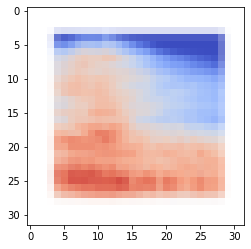

In [8]:
show_example(*dataset[0])


In [9]:
random_seed = 42
torch.manual_seed(random_seed);

In [10]:

val_size = int(len(dataset)*0.25)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)


(1500, 500)

In [11]:
val_size = val_size - 100
val_ds, test_ds = random_split(val_ds, [val_size, 100])
len(val_ds), len(test_ds)

(400, 100)

In [12]:
from torch.utils.data.dataloader import DataLoader

batch_size=32

In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

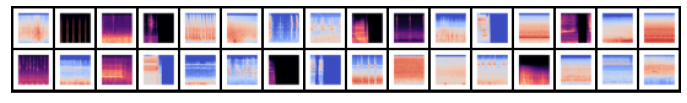

In [15]:
show_batch(train_dl)


In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 50))
        
    def forward(self, xb):
        return self.network(xb)

In [19]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 50])
out[0]: tensor([-0.0358, -0.0117, -0.0077,  0.0248, -0.0035, -0.0063,  0.0166, -0.0425,
         0.0279, -0.0224,  0.0263, -0.0281, -0.0001,  0.0157, -0.0571, -0.0018,
         0.0220,  0.0067,  0.0145, -0.0004, -0.0315, -0.0025,  0.0226,  0.0163,
         0.0092,  0.0236,  0.0250, -0.0359, -0.0491,  0.0188,  0.0392, -0.0126,
        -0.0166, -0.0242,  0.0453,  0.0187,  0.0051,  0.0328,  0.0297, -0.0328,
         0.0561, -0.0256,  0.0067, -0.0203,  0.0012, -0.0321, -0.0392,  0.0132,
         0.0152, -0.0255], grad_fn=<SelectBackward>)


In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model = to_device(Cifar10CnnModel(), device)


In [27]:
evaluate(model, val_dl)


tensor([[ 0.0262, -0.0414, -0.0371,  ..., -0.0468, -0.0081,  0.0121],
        [ 0.0262, -0.0413, -0.0370,  ..., -0.0468, -0.0083,  0.0122],
        [ 0.0262, -0.0412, -0.0371,  ..., -0.0468, -0.0083,  0.0122],
        ...,
        [ 0.0263, -0.0413, -0.0371,  ..., -0.0468, -0.0080,  0.0121],
        [ 0.0263, -0.0413, -0.0371,  ..., -0.0468, -0.0080,  0.0121],
        [ 0.0263, -0.0413, -0.0371,  ..., -0.0468, -0.0080,  0.0120]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[ 0.0262, -0.0414, -0.0370,  ..., -0.0467, -0.0081,  0.0121],
        [ 0.0263, -0.0413, -0.0371,  ..., -0.0468, -0.0081,  0.0121],
        [ 0.0263, -0.0413, -0.0371,  ..., -0.0468, -0.0081,  0.0120],
        ...,
        [ 0.0

{'val_acc': 0.013392857275903225, 'val_loss': 3.9108383655548096}

In [30]:
num_epochs = 52
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
%%time

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


tensor([[-0.5831, -0.1830, -0.1756,  ..., -0.0273, -0.4819, -0.4294],
        [-2.0559, -0.3954, -0.6019,  ..., -0.1205, -1.5564, -1.7434],
        [-2.9113, -0.5512, -0.7040,  ..., -0.1241, -2.2175, -2.3141],
        ...,
        [-0.0551, -1.9543, -1.9836,  ...,  0.3674, -1.3438,  1.2462],
        [-0.0457, -1.8156, -1.8479,  ...,  0.3375, -1.2448,  1.1541],
        [ 0.0352, -1.5049, -1.6356,  ...,  0.2459, -0.9927,  0.8951]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-1.7927, -0.3492, -0.4226,  ..., -0.0673, -1.3726, -1.4029],
        [ 0.5391, -0.3830, -1.4094,  ..., -0.2525,  0.0228, -0.4040],
        [-0.0547, -0.2210, -0.4322,  ..., -0.1248, -0.1035, -0.2584],
        ...,
        [-0.0

Epoch [0], train_loss: 3.6739, val_loss: 3.5236, val_acc: 0.0670
tensor([[-1.8934, -0.2766,  0.0214,  ...,  0.0365, -1.2696, -0.6282],
        [-2.0477, -0.3793, -1.7656,  ..., -1.1120, -1.0227, -2.8580],
        [-6.0294, -0.6124, -0.7430,  ..., -0.4324, -3.6554, -3.3812],
        ...,
        [-1.6865, -2.7559, -0.3691,  ...,  0.3637, -3.3361,  1.9019],
        [-1.3782, -2.2976, -0.3343,  ...,  0.2907, -2.7683,  1.5783],
        [-0.5371, -1.4907, -0.5386,  ..., -0.0209, -1.6590,  0.9363]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-3.2495, -0.3480, -0.1910,  ..., -0.0437, -2.0261, -1.5389],
        [ 1.4790, -0.2350, -2.2866,  ..., -1.4104,  0.7642, -1.4071],
        [-1.1366, -0.3448,  0.0

Epoch [1], train_loss: 3.4814, val_loss: 3.4172, val_acc: 0.0670
tensor([[ -5.7704,  -0.8327,   0.2802,  ...,   0.1165,  -4.5414,  -0.4548],
        [ -3.8440,  -0.6970,  -2.7429,  ...,  -2.3600,  -2.6736,  -4.8788],
        [-11.3310,  -0.7648,  -1.1996,  ...,  -2.1775,  -7.2045,  -5.7060],
        ...,
        [ -1.2471,  -2.7820,  -0.3765,  ...,   0.3016,  -3.4312,   1.0400],
        [ -0.7930,  -1.9333,  -0.3197,  ...,   0.1680,  -2.3318,   0.6886],
        [  0.1738,  -1.0234,  -0.6936,  ...,  -0.2073,  -0.8671,   0.1176]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-7.5759e+00, -6.6605e-01,  5.9482e-02,  ..., -2.4680e-01,
         -5.2263e+00, -2.4609e+00],
        [ 2.2636e+00, -3.5295e-0

Epoch [2], train_loss: 3.3703, val_loss: 3.3459, val_acc: 0.0759
tensor([[-4.3571, -0.2663, -0.1263,  ..., -0.5833, -2.4324, -0.4585],
        [-2.5764, -0.4871, -1.5676,  ..., -1.3513, -1.1895, -2.8893],
        [-7.1738, -0.5263, -1.0478,  ..., -1.9454, -3.4087, -3.7199],
        ...,
        [-1.8253, -2.4524, -1.1481,  ..., -0.5130, -3.8304,  0.9254],
        [-1.0661, -1.5381, -0.8171,  ..., -0.3427, -2.3152,  0.4789],
        [-0.1289, -0.6235, -0.8763,  ..., -0.3543, -0.7380, -0.0156]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-5.5430, -0.6079, -0.1040,  ..., -0.3663, -2.7967, -1.9628],
        [ 1.4555, -0.1330, -2.6588,  ..., -1.0011,  1.0925, -1.8964],
        [-4.0066, -0.2104, -0.4

Epoch [3], train_loss: 3.2644, val_loss: 3.2331, val_acc: 0.0960
tensor([[-5.8305, -0.6687,  0.1102,  ..., -0.2578, -3.4199, -0.9153],
        [-5.4551, -0.6415, -0.6618,  ..., -1.1053, -2.6820, -3.5636],
        [-8.9782, -0.8405, -0.6845,  ..., -1.5930, -4.1569, -5.1510],
        ...,
        [-2.9520, -3.1479, -1.4664,  ..., -0.4524, -6.2910,  1.0219],
        [-1.8105, -1.9315, -0.9580,  ..., -0.3187, -3.8209,  0.4809],
        [-0.5928, -0.9544, -1.2303,  ..., -0.2201, -1.7662, -0.3248]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-6.8715, -0.9382,  0.0742,  ..., -0.2799, -3.3280, -2.8634],
        [ 0.7410, -0.4520, -2.6845,  ..., -0.5136, -0.0373, -1.9734],
        [-5.1480, -0.4056, -0.2

Epoch [4], train_loss: 3.0963, val_loss: 3.1412, val_acc: 0.1250
tensor([[-11.4229,  -1.3459,   0.9249,  ...,  -0.4249,  -7.9177,  -0.7383],
        [ -3.4564,  -0.5531,  -2.5633,  ...,  -1.8073,  -0.6654,  -4.2805],
        [-12.9682,  -0.8712,  -1.5081,  ...,  -3.5274,  -4.8941,  -7.1808],
        ...,
        [ -6.8552,  -3.6303,   0.1143,  ...,  -0.5596, -10.8100,   3.4457],
        [ -4.8603,  -1.6323,   0.2622,  ...,  -0.1867,  -5.3126,   0.9215],
        [ -2.0193,  -1.1044,  -0.4216,  ...,  -0.4355,  -3.5577,   0.8839]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-14.1452,  -2.4134,   0.9986,  ...,   0.4389,  -9.2698,  -3.6260],
        [  0.9670,  -0.1918,  -2.2351,  ...,  -0.3509,   0.

Epoch [5], train_loss: 2.9710, val_loss: 2.9352, val_acc: 0.1786
tensor([[-14.3376,  -2.5950,   0.8478,  ...,  -0.0310,  -9.1613,  -2.1341],
        [ -6.0091,  -1.2403,  -1.3498,  ...,  -1.3552,  -2.2856,  -4.2159],
        [-12.2819,  -1.8265,  -1.7389,  ...,  -2.6823,  -5.3146,  -7.4359],
        ...,
        [ -7.3884,  -3.5835,  -0.1384,  ...,  -0.7841,  -8.9503,   1.7679],
        [ -4.9285,  -1.6891,   0.1378,  ...,  -0.1877,  -4.5520,  -0.1424],
        [ -2.6286,  -1.2532,  -0.5279,  ...,  -0.5534,  -3.2755,  -0.2162]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-14.8011,  -2.6425,   1.0261,  ...,   1.0558,  -7.2346,  -4.7416],
        [  0.9326,  -0.2805,  -2.6034,  ...,  -0.6377,   0.

Epoch [6], train_loss: 2.8135, val_loss: 2.8466, val_acc: 0.1942
tensor([[-14.1377,  -1.4851,   1.1067,  ...,  -0.5436,  -7.8827,  -2.9528],
        [ -5.8683,  -1.2205,  -1.5155,  ...,  -1.9565,  -2.0951,  -3.8665],
        [-15.5054,  -2.1214,  -1.8189,  ...,  -3.8431,  -6.9153,  -8.6205],
        ...,
        [ -6.1700,  -3.1671,  -0.5517,  ...,  -1.7964,  -9.4691,   3.3368],
        [ -5.9997,  -1.6918,   0.2138,  ...,  -0.2696,  -5.3256,  -0.4911],
        [ -2.5480,  -1.0168,  -0.9658,  ...,  -0.8035,  -3.5491,  -0.4531]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-14.4278,  -1.6438,   1.0401,  ...,  -0.4391,  -6.5682,  -5.1743],
        [  1.3740,  -0.3934,  -3.5442,  ...,  -0.8712,   1.

Epoch [7], train_loss: 2.7434, val_loss: 2.8280, val_acc: 0.1875
tensor([[-16.1564,  -3.0382,   1.5909,  ...,  -0.8252, -12.8541,  -3.9308],
        [ -6.4422,  -1.1193,  -1.5401,  ...,  -1.6686,  -2.2645,  -4.0519],
        [-17.0696,  -1.6132,  -2.3172,  ...,  -3.8435,  -8.6639, -10.1768],
        ...,
        [ -2.0232,  -3.2388,  -1.8172,  ...,  -0.5170,  -7.2954,   0.0527],
        [ -5.2329,  -2.3837,   0.0956,  ...,  -0.4707,  -6.2351,  -1.1983],
        [ -1.6912,  -1.7138,  -2.4829,  ...,  -0.4688,  -4.4657,  -2.2868]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-16.1469,  -1.9584,   1.2211,  ...,   0.4378,  -8.3921,  -6.3415],
        [  1.5762,  -0.4051,  -4.2230,  ...,  -0.5190,   0.

Epoch [8], train_loss: 2.6408, val_loss: 2.8632, val_acc: 0.1897
tensor([[-14.3906,  -2.9716,   0.9039,  ...,  -0.4695, -11.1638,  -1.8467],
        [ -4.3298,  -0.9515,  -2.2477,  ...,  -1.8061,  -1.0373,  -2.7175],
        [-13.6201,  -1.7937,  -3.5232,  ...,  -4.1754,  -7.1879,  -7.6672],
        ...,
        [ -4.5218,  -3.3894,  -0.5267,  ...,  -1.2011,  -8.4807,   3.0220],
        [ -6.4937,  -3.0003,   0.1189,  ...,  -0.3355,  -7.0814,  -0.9025],
        [ -3.7441,  -2.1195,  -1.3098,  ...,  -0.6413,  -5.2533,  -1.3227]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-13.5950,  -2.5058,   0.4985,  ...,  -0.0294,  -8.1603,  -4.7522],
        [  0.2735,  -0.2905,  -2.9163,  ...,  -0.6786,   0.

Epoch [9], train_loss: 2.5547, val_loss: 2.6625, val_acc: 0.2522
tensor([[-20.9441,  -4.0958,   0.4521,  ...,  -0.8101, -16.6206,  -1.9278],
        [ -5.2951,  -1.1401,  -2.2669,  ...,  -1.5208,  -1.6417,  -3.4289],
        [-18.0704,  -2.1261,  -4.9689,  ...,  -4.7375, -11.0085, -11.6864],
        ...,
        [ -5.5082,  -4.1480,  -2.0280,  ...,  -2.3421, -13.2433,   4.3511],
        [ -9.0369,  -4.4049,  -0.5203,  ...,  -1.4373, -11.6063,   0.0608],
        [ -4.8197,  -3.5102,  -3.0693,  ...,  -0.8283,  -9.3431,  -2.1576]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-19.5687,  -3.0634,   0.5947,  ...,   0.9375, -10.9533,  -6.5915],
        [  0.9993,  -0.3380,  -4.5073,  ...,  -0.9303,   0.

Epoch [10], train_loss: 2.4703, val_loss: 2.6761, val_acc: 0.2634
tensor([[-17.0123,  -1.8287,   1.0390,  ...,  -1.7792, -10.9177,  -1.8483],
        [ -6.3586,  -1.0283,  -2.0366,  ...,  -2.0565,  -1.7378,  -2.7237],
        [-15.1942,  -1.8992,  -3.2977,  ...,  -3.8448,  -7.3606,  -8.3104],
        ...,
        [ -3.1236,  -3.8443,  -1.3207,  ...,  -2.7116,  -9.8893,   3.0105],
        [ -5.0344,  -3.0907,  -0.2495,  ...,  -1.9595,  -7.9713,   0.1992],
        [ -2.3085,  -2.1850,  -2.4507,  ...,  -0.8282,  -5.1296,  -1.9899]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-16.6372,  -2.0323,   1.4355,  ...,   0.5001,  -7.6590,  -4.4513],
        [  1.3349,  -0.3892,  -3.9491,  ...,  -1.0708,   1

Epoch [11], train_loss: 2.3897, val_loss: 2.6662, val_acc: 0.2344
tensor([[-20.2504,  -2.9305,   2.1411,  ...,  -1.2756, -14.2680,  -2.7135],
        [ -5.7234,  -1.3920,  -1.7698,  ...,  -1.6870,  -1.9402,  -2.7993],
        [-15.1402,  -1.8798,  -4.4600,  ...,  -4.2353, -10.1893, -10.6614],
        ...,
        [ -3.2160,  -5.1078,  -1.1115,  ...,  -1.9597, -12.4101,   3.7863],
        [ -5.4441,  -3.4677,   0.1347,  ...,  -1.8653,  -9.3792,  -0.1061],
        [ -2.2155,  -2.8057,  -3.3186,  ...,  -0.9774,  -6.8582,  -3.3577]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-17.2677,  -2.8284,   1.7768,  ...,   1.0654,  -9.0859,  -5.3836],
        [  1.0185,  -0.6186,  -4.9572,  ...,  -0.5103,   0

Epoch [12], train_loss: 2.3337, val_loss: 2.6555, val_acc: 0.2679
tensor([[-20.9140,  -1.9128,   0.4291,  ...,  -1.6322,  -9.8567,  -2.1880],
        [ -6.7778,  -1.0319,  -1.8392,  ...,  -1.9245,  -1.9974,  -3.1678],
        [-18.6455,  -1.7835,  -3.2173,  ...,  -4.4051,  -9.4826, -10.2611],
        ...,
        [ -4.5630,  -1.9982,  -1.8245,  ...,  -2.7126, -12.1616,   3.0954],
        [ -7.9122,  -1.5806,  -0.3985,  ...,  -1.8722,  -8.0789,   0.2056],
        [ -3.8424,  -2.7893,  -3.9156,  ...,  -1.5993,  -7.1810,  -3.6870]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-21.6513,  -3.5293,   2.1561,  ...,   0.7851, -10.2524,  -5.7324],
        [ -0.7189,  -0.3363,  -4.1260,  ...,  -1.5528,  -0

Epoch [13], train_loss: 2.3096, val_loss: 2.7084, val_acc: 0.2679
tensor([[-23.4674,  -3.5635,   1.8554,  ...,  -3.2546, -19.1486,  -3.1273],
        [ -5.9927,  -0.9919,  -1.6333,  ...,  -1.9523,  -2.2161,  -3.4179],
        [-16.4537,  -0.8299,  -4.1221,  ...,  -4.7589, -10.5604, -10.2332],
        ...,
        [ -3.0972,  -5.9511,  -0.9081,  ...,  -3.2949, -15.4124,   2.5452],
        [ -6.8185,  -4.0587,   0.5978,  ...,  -2.8580, -11.9817,  -0.5631],
        [ -4.8082,  -4.4213,  -2.9195,  ...,  -1.7438, -11.0554,  -4.5866]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-20.8043,  -2.9250,   2.0305,  ...,   0.4162, -11.4207,  -6.0570],
        [  0.5231,  -0.4660,  -3.7591,  ...,  -1.1520,   0

Epoch [14], train_loss: 2.1924, val_loss: 2.6346, val_acc: 0.3036
tensor([[-31.1715,  -4.3373,   0.6427,  ...,  -1.6708, -12.3043,  -3.6023],
        [-12.1903,  -2.8005,  -2.4759,  ...,  -2.8984,  -4.5546,  -4.9395],
        [-29.3192,  -3.9665,  -3.5751,  ...,  -4.8518, -16.2216, -15.2196],
        ...,
        [ -2.3688,  -4.9547,  -0.6696,  ...,  -2.8529, -11.5407,   3.8595],
        [ -6.9112,  -2.8180,   0.0848,  ...,  -2.3302,  -7.6693,   0.3248],
        [ -3.3867,  -3.1950,  -3.9341,  ...,  -2.1512,  -6.8463,  -4.5456]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-3.2269e+01, -5.8703e+00,  3.2951e+00,  ...,  1.6445e+00,
         -1.5064e+01, -7.6164e+00],
        [-2.4098e-02, -4.7022e-

Epoch [15], train_loss: 2.0918, val_loss: 2.8087, val_acc: 0.2723
tensor([[-2.9422e+01, -6.4373e+00,  1.2393e+00,  ..., -5.0741e+00,
         -2.1251e+01, -2.9553e+00],
        [-1.0451e+01, -2.3075e+00, -2.6581e+00,  ..., -2.3833e+00,
         -4.3108e+00, -4.0218e+00],
        [-2.2192e+01, -2.8418e+00, -6.7635e+00,  ..., -5.1903e+00,
         -1.3467e+01, -1.4279e+01],
        ...,
        [-3.9078e+00, -7.2845e+00, -5.0928e-01,  ..., -4.4463e+00,
         -1.6277e+01,  4.4310e+00],
        [-6.9474e+00, -5.3248e+00, -2.5236e-02,  ..., -3.5497e+00,
         -1.2653e+01, -1.3096e-01],
        [-2.5597e+00, -4.1000e+00, -1.9430e+00,  ..., -2.3953e+00,
         -1.2076e+01, -3.7828e+00]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 2

Epoch [16], train_loss: 2.0259, val_loss: 2.6827, val_acc: 0.3103
tensor([[-34.8123,  -6.7200,   3.7551,  ...,  -4.5638, -21.9194,  -3.3238],
        [ -8.2559,  -1.3892,  -2.6404,  ...,  -2.0261,  -3.6020,  -4.3548],
        [-18.0317,  -0.8505,  -6.4539,  ...,  -4.8670, -10.6826, -12.0071],
        ...,
        [ -1.3526,  -5.5732,   0.2065,  ...,  -3.2819, -12.2707,   3.5774],
        [ -7.4487,  -3.6201,   0.8313,  ...,  -3.7014, -10.6476,   0.3816],
        [ -2.4410,  -4.2060,  -2.6683,  ...,  -1.9093, -10.8869,  -5.5284]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-27.7266,  -4.9246,   3.9667,  ...,   1.2312, -12.4845,  -6.1415],
        [  1.9358,  -0.3606,  -6.0489,  ...,  -1.5592,   0

Epoch [17], train_loss: 2.0005, val_loss: 2.7167, val_acc: 0.2835
tensor([[-28.2703,  -4.9797,   0.6615,  ...,  -3.8739, -14.5448,  -1.4787],
        [ -8.2613,  -1.3864,  -2.4907,  ...,  -1.6654,  -3.5735,  -3.3068],
        [-17.0529,  -1.5695,  -7.0878,  ...,  -3.3701, -11.6097, -13.2198],
        ...,
        [ -3.5589,  -4.6886,  -1.1497,  ...,  -3.9640, -11.3592,   4.0980],
        [ -8.6177,  -4.0965,  -0.1411,  ...,  -3.6434, -10.8789,  -0.1817],
        [ -4.8942,  -3.2961,  -3.9296,  ...,  -1.3550, -10.5477,  -5.9131]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-2.4630e+01, -4.6390e+00,  2.3278e+00,  ...,  1.2155e+00,
         -1.1146e+01, -5.0538e+00],
        [-1.9298e+00, -9.3873e-

Epoch [18], train_loss: 1.8752, val_loss: 2.5202, val_acc: 0.3304
tensor([[-37.8521,  -5.3147,   1.8290,  ...,  -3.7218, -15.0099,  -4.2801],
        [-11.1755,  -2.2238,  -3.3527,  ...,  -2.5365,  -3.8741,  -4.4518],
        [-26.7019,  -2.4967,  -4.8909,  ...,  -4.8909, -12.7481, -15.0872],
        ...,
        [ -4.0449,  -4.1095,  -0.6593,  ...,  -3.9463, -13.4985,   2.7863],
        [ -9.9304,  -4.4111,   0.7759,  ...,  -3.3826, -10.6492,  -1.0942],
        [ -6.2406,  -4.2984,  -1.7125,  ...,  -2.6553, -12.5617,  -6.2450]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-34.7965,  -6.4542,   3.3235,  ...,   1.0074, -12.2550,  -6.8493],
        [ -3.6120,  -0.5776,  -5.5822,  ...,  -3.0345,  -0

Epoch [19], train_loss: 1.8282, val_loss: 2.6881, val_acc: 0.2768
tensor([[-40.1579,  -8.8808,   2.6505,  ...,  -5.5412, -21.0480,  -4.1174],
        [-11.1715,  -2.0208,  -2.9835,  ...,  -1.8478,  -2.6564,  -3.7781],
        [-22.3870,  -0.1530,  -9.6337,  ...,  -6.0710, -14.6498, -16.8745],
        ...,
        [ -3.2062,  -5.7997,  -0.8596,  ...,  -4.6760, -15.6721,   4.0353],
        [ -9.8272,  -6.1608,  -0.2121,  ...,  -3.4456, -13.1133,  -1.3862],
        [ -3.5585,  -5.3244,  -3.8296,  ...,  -3.0279, -14.4903,  -7.1705]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-29.7288,  -5.6054,   2.7297,  ...,  -0.5486, -12.5984,  -7.3280],
        [ -2.2065,  -0.3076,  -8.1820,  ...,  -3.1202,  -1

Epoch [20], train_loss: 1.7638, val_loss: 2.6219, val_acc: 0.3103
tensor([[-40.8782,  -9.5172,   1.9517,  ...,  -3.4278, -20.7453,  -3.6651],
        [-10.0448,  -2.2501,  -3.6039,  ...,  -1.8224,  -3.5340,  -4.3950],
        [-24.9367,  -0.4307,  -8.3356,  ...,  -4.4428, -14.3378, -15.9470],
        ...,
        [ -4.0432,  -5.2958,  -2.0580,  ...,  -5.8130, -15.5977,   6.2843],
        [-11.8716,  -5.9173,  -0.6614,  ...,  -3.7061, -14.1371,  -1.1258],
        [ -6.7638,  -4.0167,  -5.5365,  ...,  -3.5841, -15.0753,  -8.5453]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-32.6303,  -6.4380,   3.2326,  ...,   2.0951, -12.4861,  -7.2216],
        [ -3.6830,  -1.0686,  -8.3984,  ...,  -4.2800,  -1

Epoch [21], train_loss: 1.5953, val_loss: 2.5761, val_acc: 0.3415
tensor([[-4.7105e+01, -1.4020e+01,  4.3452e+00,  ..., -4.6451e+00,
         -2.7241e+01, -5.7462e+00],
        [-1.1876e+01, -2.5864e+00, -3.1850e+00,  ..., -1.2770e+00,
         -5.9043e+00, -4.1647e+00],
        [-2.2087e+01,  4.3474e-01, -1.0377e+01,  ..., -5.7757e+00,
         -1.4358e+01, -1.7861e+01],
        ...,
        [-2.8568e+00, -5.8087e+00, -1.2485e+00,  ..., -5.0327e+00,
         -1.4949e+01,  4.1839e+00],
        [-1.1930e+01, -7.2377e+00, -4.2190e-02,  ..., -3.3775e+00,
         -1.4272e+01, -1.9391e+00],
        [-4.7717e+00, -5.4649e+00, -5.1252e+00,  ..., -3.5099e+00,
         -1.5473e+01, -1.0230e+01]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 2

Epoch [22], train_loss: 1.5915, val_loss: 2.6692, val_acc: 0.3371
tensor([[-52.1002, -11.7942,   2.7510,  ...,  -5.0190, -21.6008,  -3.6111],
        [-13.1564,  -2.9824,  -4.2144,  ...,  -1.6389,  -5.1217,  -5.9139],
        [-27.6585,  -0.7401, -12.0064,  ...,  -6.7827, -17.2379, -23.1225],
        ...,
        [ -5.8496,  -9.6956,  -1.3126,  ...,  -6.1554, -19.4567,   6.0922],
        [-15.8586,  -8.0677,  -0.0749,  ...,  -4.8342, -14.5938,  -0.1015],
        [ -8.4075,  -7.1084,  -9.0303,  ...,  -5.5190, -14.9469, -13.6744]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-38.1466,  -7.0923,   3.9440,  ...,   0.4138, -11.8589,  -6.4567],
        [ -4.7591,  -1.4787, -11.0855,  ...,  -4.3219,  -3

Epoch [23], train_loss: 1.4325, val_loss: 2.8831, val_acc: 0.3170
tensor([[-55.2045, -19.8333,   5.5508,  ...,  -5.5708, -30.2508,  -4.5012],
        [-11.4008,  -3.2668,  -3.6495,  ...,  -1.1468,  -4.7922,  -4.7996],
        [-25.4039,  -1.2613, -10.7239,  ...,  -6.8401, -16.2352, -21.4388],
        ...,
        [ -4.2253,  -9.1758,  -1.9604,  ...,  -6.2228, -17.1703,   6.1040],
        [-12.9155,  -8.3740,   0.1192,  ...,  -4.3446, -12.4746,  -0.3451],
        [ -3.8395,  -6.7562,  -6.7851,  ...,  -5.1839, -18.1473, -11.9634]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-33.4437,  -6.4751,   2.4901,  ...,  -0.6710, -10.2863,  -5.9811],
        [ -1.2121,  -1.9434,  -8.4499,  ...,  -3.2486,  -1

Epoch [24], train_loss: 1.3470, val_loss: 2.7675, val_acc: 0.3527
tensor([[-58.4706, -21.0192,   7.3090,  ...,  -6.6700, -26.5875,  -6.4601],
        [-11.7901,  -2.7708,  -2.7783,  ...,  -1.5606,  -4.8745,  -4.3757],
        [-26.7967,  -1.2079, -10.9748,  ...,  -8.8305, -17.3788, -23.8748],
        ...,
        [ -4.2270,  -6.3214,  -0.5846,  ...,  -5.0222, -11.9301,   4.1323],
        [-14.6534, -10.0825,  -0.6058,  ...,  -5.4049, -14.5619,  -2.7849],
        [ -7.7971,  -7.6266,  -6.7408,  ...,  -6.8555, -18.6117, -13.0396]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-41.1178,  -9.1508,   4.6012,  ...,  -0.4474, -12.4566,  -8.1513],
        [ -2.3767,  -1.7860,  -8.9088,  ...,  -3.7108,  -2

Epoch [25], train_loss: 1.2058, val_loss: 2.8426, val_acc: 0.3415
tensor([[-50.6767, -13.9933,   2.1308,  ...,  -5.9128, -19.2085,  -4.9613],
        [ -9.2551,  -2.7370,  -4.5728,  ...,  -0.8099,  -3.2655,  -6.4206],
        [-28.4213,  -3.8031, -10.2342,  ...,  -8.2963, -19.6079, -24.0454],
        ...,
        [ -3.6820,  -4.3594,  -1.4190,  ...,  -2.8552,  -9.5946,   2.7970],
        [ -9.1376,  -7.0824,  -1.0402,  ...,  -2.8167, -10.2542,  -2.5220],
        [ -4.8650,  -4.1058,  -6.4135,  ...,  -5.4350, -14.2037,  -9.9944]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-34.3222,  -7.8021,   3.5357,  ...,   1.0559, -10.1684,  -7.0493],
        [ -1.2909,  -1.7932,  -8.1070,  ...,  -2.5056,  -0

Epoch [26], train_loss: 1.2053, val_loss: 2.9428, val_acc: 0.3214
tensor([[-59.0080, -22.1583,   7.3689,  ...,  -8.5129, -28.7546,  -7.8702],
        [ -8.9353,  -2.4635,  -3.1569,  ...,  -0.2651,  -2.9601,  -4.5106],
        [-19.9606,  -0.6617, -10.0258,  ...,  -6.6323, -12.7070, -19.1124],
        ...,
        [ -6.0654,  -6.0709,  -1.2516,  ...,  -5.6369, -14.6770,   5.7583],
        [-13.5804,  -8.9561,  -1.3133,  ...,  -5.5221, -11.9822,  -2.3720],
        [-12.0012,  -7.2950,  -8.4693,  ...,  -7.2914, -17.6445, -14.1041]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-33.1912,  -5.6194,   2.7095,  ...,  -1.9645,  -8.2281,  -6.4395],
        [ -4.0675,  -1.9656,  -8.9204,  ...,  -2.9575,  -1

Epoch [27], train_loss: 1.0825, val_loss: 2.9876, val_acc: 0.3036
tensor([[-81.9793, -30.1900,  10.6301,  ..., -11.2431, -45.1560,  -5.8132],
        [-10.1130,  -2.2185,  -3.5849,  ...,  -0.4926,  -3.7445,  -5.0494],
        [-27.5813,  -0.6362, -13.2706,  ...,  -9.7756, -17.3219, -23.9243],
        ...,
        [ -8.3788, -10.0063,  -0.9548,  ...,  -6.2349, -21.3248,   6.1973],
        [-18.1567, -12.4766,  -1.4414,  ...,  -5.7805, -18.2498,  -3.3448],
        [-12.3405, -12.1776, -11.3285,  ..., -11.2702, -28.5293, -19.1035]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-49.1593,  -9.4955,   1.2495,  ...,  -1.5661, -17.4760,  -8.1244],
        [ -3.1552,  -3.6695, -12.0429,  ...,  -5.4843,  -5

Epoch [28], train_loss: 0.9673, val_loss: 3.4098, val_acc: 0.3393
tensor([[-67.2069, -22.4720,   4.5855,  ..., -11.4653, -33.4672,  -4.3663],
        [-12.9524,  -3.2197,  -4.9319,  ...,  -0.8445,  -3.8386,  -7.3549],
        [-28.5187,  -1.7729, -19.4528,  ..., -14.5591, -19.2647, -30.3495],
        ...,
        [ -7.9669,  -7.8061,  -0.3348,  ...,  -3.6503, -16.2182,  -0.7161],
        [-18.4648, -11.6038,  -2.5859,  ...,  -7.1494, -17.7359,  -3.0121],
        [-17.7719, -12.1129, -11.6620,  ..., -12.6420, -27.8097, -21.2028]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-42.8331,  -8.9035,   2.9630,  ...,  -2.1277, -12.1416,  -8.4982],
        [ -7.6853,  -2.1621, -13.2369,  ...,  -7.7499,  -5

Epoch [29], train_loss: 0.8685, val_loss: 3.5078, val_acc: 0.3393
tensor([[-67.0349, -26.9042,   5.5989,  ..., -14.0375, -34.7970,  -2.2214],
        [-10.1565,  -2.9690,  -2.8197,  ...,  -0.6427,  -3.5846,  -5.9026],
        [-23.2603,  -0.7091, -14.5377,  ..., -11.5352, -15.5427, -24.5102],
        ...,
        [ -6.9355, -10.6473,  -2.1901,  ...,  -7.5861, -16.5591,   6.9537],
        [-18.0680, -15.1636,  -4.1793,  ...,  -8.1283, -21.6540,  -4.7499],
        [-11.5950,  -6.9345, -12.5654,  ..., -14.6676, -24.5303, -15.6004]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-42.7188,  -9.3485,   3.2702,  ...,  -2.8296, -11.3734,  -6.0308],
        [ -4.2943,  -2.8440, -15.4546,  ...,  -6.5685,  -4

Epoch [30], train_loss: 0.8346, val_loss: 3.2963, val_acc: 0.3438
tensor([[-92.7540, -38.9784,  10.0278,  ..., -13.5196, -52.3419,  -6.6698],
        [-18.0367,  -3.8612,  -6.2494,  ...,  -1.3771,  -6.7340,  -9.5018],
        [-37.1462,  -2.7267, -14.0139,  ..., -14.6775, -22.0890, -30.4878],
        ...,
        [ -7.9561, -11.3828,  -1.0270,  ...,  -5.2502, -15.7112,   2.2138],
        [-22.9542, -17.6068,  -1.7039,  ...,  -8.0577, -19.1835,  -4.6031],
        [-21.0101, -11.7378, -16.5706,  ..., -18.5646, -25.7523, -21.2305]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-56.3201, -11.6146,   3.8319,  ...,  -2.3636, -18.3760,  -7.6427],
        [ -9.2459,  -4.4194, -16.6829,  ...,  -8.0703,  -4

Epoch [31], train_loss: 0.7015, val_loss: 3.9576, val_acc: 0.3616
tensor([[-89.1955, -28.8001,   4.2400,  ..., -11.3963, -33.6873,  -5.2023],
        [-22.4860,  -5.5722,  -3.6190,  ...,  -2.7019, -10.3811,  -8.7478],
        [-43.0914,  -4.5899, -23.2783,  ..., -22.4013, -29.7492, -43.0772],
        ...,
        [ -9.4793, -10.8014,  -3.3550,  ...,  -7.8995, -17.7518,   3.8389],
        [-20.5656, -17.2558,  -4.2271,  ...,  -9.7194, -23.6588,  -5.9772],
        [-14.1196,  -8.9072, -14.1864,  ..., -16.9808, -25.4898, -19.3889]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-62.9011, -11.7435,   4.6920,  ...,  -4.9461, -18.8543,  -9.6161],
        [ -6.0554,  -3.7690, -15.7110,  ...,  -5.5322,  -0

Epoch [32], train_loss: 0.6867, val_loss: 3.9245, val_acc: 0.3348
tensor([[-102.8539,  -34.1863,    9.0753,  ...,  -14.8366,  -36.1647,
           -9.9916],
        [ -19.6034,   -4.7519,   -4.7261,  ...,   -0.7472,   -6.1634,
           -8.1252],
        [ -35.9933,   -2.4363,  -17.0559,  ...,  -17.9267,  -25.4852,
          -33.1282],
        ...,
        [  -6.1310,   -7.3366,   -1.5901,  ...,   -5.9254,  -13.6034,
            4.6161],
        [ -24.0557,  -16.5594,   -3.1001,  ...,   -7.6758,  -21.7253,
           -7.7505],
        [ -18.5593,   -9.3809,  -17.3720,  ...,  -20.7700,  -26.8138,
          -26.2031]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-69.4464, -13.7333,   7.6472,  ...,  -3.13

Epoch [33], train_loss: 0.6870, val_loss: 4.0948, val_acc: 0.3638
tensor([[-109.3614,  -42.2990,   10.4200,  ...,  -12.1358,  -40.8958,
           -8.1733],
        [ -19.4326,   -7.3773,   -4.2652,  ...,   -1.4584,  -10.4505,
          -10.1934],
        [ -41.2058,   -4.9681,  -17.6395,  ...,  -18.3199,  -24.0565,
          -36.3118],
        ...,
        [  -8.4506,   -5.8746,   -2.8009,  ...,   -5.4414,  -12.9751,
            5.1118],
        [ -19.6974,  -14.4733,   -3.1530,  ...,   -8.4073,  -19.4651,
           -4.5504],
        [ -14.5689,   -8.8733,  -13.7850,  ...,  -22.3000,  -37.0608,
          -22.7522]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-69.3059, -15.0601,   6.7426,  ...,  -0.79

Epoch [34], train_loss: 0.6230, val_loss: 4.2616, val_acc: 0.3393
tensor([[-87.2926, -35.5662,   6.5988,  ..., -14.0720, -34.1293,  -9.4951],
        [-17.8216,  -5.3812,  -5.2371,  ...,  -0.5230,  -8.4251, -11.6728],
        [-41.2381,  -4.5094, -12.2506,  ..., -14.8573, -22.0791, -35.4271],
        ...,
        [ -5.8565, -10.4047,  -4.2743,  ...,  -6.3837, -13.6424,   4.2503],
        [-19.8082, -18.7430,  -4.1304,  ...,  -8.8802, -23.1248,  -7.7348],
        [-16.1322, -10.0354, -14.2735,  ..., -18.3980, -26.8402, -24.1760]],
       device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-49.3738, -10.2815,   3.0207,  ...,  -5.2486, -13.5078, -10.2493],
        [ -5.2752,  -3.8633, -15.0758,  ...,  -7.5161,  -4

Epoch [35], train_loss: 0.6700, val_loss: 4.1608, val_acc: 0.3393
tensor([[-123.2702,  -48.9694,    6.3693,  ...,  -29.1507,  -55.6487,
          -12.6258],
        [ -21.7879,   -5.5089,   -6.2792,  ...,   -2.3603,  -10.9027,
          -10.0543],
        [ -44.9567,   -3.3764,  -16.8785,  ...,  -19.1076,  -25.1836,
          -32.0755],
        ...,
        [  -6.0760,  -10.1443,   -2.7625,  ...,  -10.0574,  -16.5924,
            8.0785],
        [ -25.5000,  -22.3839,   -4.1785,  ...,  -13.3562,  -27.8937,
           -7.3737],
        [ -21.3915,  -12.4827,  -18.8749,  ...,  -29.2068,  -41.4289,
          -27.0066]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-6.8857e+01, -1.4501e+01,  2.5825e+00,  ..

Epoch [36], train_loss: 0.3908, val_loss: 4.8320, val_acc: 0.3638
tensor([[-124.4454,  -45.6844,   11.2469,  ...,  -19.7302,  -47.9256,
           -9.2897],
        [ -23.6365,   -8.1780,   -7.6981,  ...,   -4.2689,  -15.0745,
          -16.4226],
        [ -51.6313,   -3.9706,  -23.3703,  ...,  -26.3551,  -35.4767,
          -48.6099],
        ...,
        [  -9.1199,   -9.3635,   -1.8717,  ...,   -5.9166,  -15.3852,
            4.5784],
        [ -26.7236,  -20.9644,   -5.4116,  ...,  -13.0950,  -28.9020,
           -7.6566],
        [ -23.1077,  -11.4541,  -17.3878,  ...,  -23.5432,  -37.0857,
          -24.3555]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-72.5813, -15.6924,   6.1086,  ...,  -4.85

Epoch [37], train_loss: 0.4234, val_loss: 5.0326, val_acc: 0.3237
tensor([[-109.8427,  -46.5107,   11.2726,  ...,  -14.9429,  -38.4853,
           -9.4673],
        [ -16.8454,   -5.0178,   -5.0353,  ...,   -2.2620,   -8.5285,
           -8.8329],
        [ -37.5151,   -0.8189,  -14.0312,  ...,  -19.2495,  -25.0592,
          -32.3482],
        ...,
        [  -6.9971,   -8.4936,   -1.4686,  ...,   -3.9707,  -11.7655,
            2.0455],
        [ -23.5864,  -17.3273,   -2.4215,  ...,  -10.4863,  -20.0785,
           -5.7870],
        [ -21.8482,   -8.2275,  -19.3458,  ...,  -23.9165,  -24.7908,
          -24.1338]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-56.1635, -13.3432,   6.4370,  ...,  -3.03

Epoch [38], train_loss: 0.5704, val_loss: 4.1932, val_acc: 0.3839
tensor([[-152.3049,  -64.1299,    8.9309,  ...,  -27.6172,  -61.3133,
          -19.3250],
        [ -29.2856,   -7.7434,   -8.5493,  ...,   -2.7194,  -13.8812,
          -15.7285],
        [ -49.1769,   -3.2923,  -21.9785,  ...,  -26.6707,  -32.2159,
          -45.4613],
        ...,
        [  -9.3614,  -14.3488,   -2.9005,  ...,   -5.1914,  -15.8504,
            4.2996],
        [ -32.9910,  -24.0500,   -4.8500,  ...,  -15.9706,  -30.7683,
           -8.2421],
        [ -31.9971,  -14.5430,  -25.7279,  ...,  -34.0059,  -37.3974,
          -36.1280]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-72.0347, -16.0833,   3.6989,  ...,  -9.27

Epoch [39], train_loss: 0.2971, val_loss: 5.7300, val_acc: 0.3281
tensor([[-140.6223,  -58.1032,   15.0174,  ...,  -20.8478,  -56.0292,
          -14.8477],
        [ -21.1251,   -5.4399,   -6.8014,  ...,   -2.5129,  -10.4825,
          -13.9974],
        [ -43.0098,   -5.3277,  -24.3295,  ...,  -25.7504,  -28.8456,
          -48.1424],
        ...,
        [ -11.7307,  -10.0625,   -4.1191,  ...,  -10.5478,  -18.0994,
            8.6693],
        [ -27.3554,  -26.9548,   -3.6833,  ...,  -10.0871,  -30.8528,
          -10.9287],
        [ -27.1601,  -14.4969,  -15.7024,  ...,  -23.8477,  -42.0136,
          -28.9290]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-55.9038, -11.7402,   3.6075,  ...,  -7.08

Epoch [40], train_loss: 0.3030, val_loss: 5.3206, val_acc: 0.3795
tensor([[-114.1087,  -48.9536,   11.5322,  ...,  -13.9808,  -44.3285,
          -11.4915],
        [ -20.6233,   -8.0881,  -11.2947,  ...,   -3.3603,  -11.9594,
          -18.4284],
        [ -51.6912,   -5.0399,  -28.6464,  ...,  -28.9127,  -31.5459,
          -58.8541],
        ...,
        [ -10.8609,  -13.5202,   -5.7949,  ...,  -10.6021,  -20.2486,
           10.2852],
        [ -25.4194,  -20.0156,   -3.0747,  ...,   -8.7626,  -22.5730,
           -6.3735],
        [ -24.7040,  -15.4093,  -20.7021,  ...,  -26.8304,  -35.2202,
          -30.5073]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-65.3676, -16.6599,   7.7351,  ...,  -6.18

Epoch [41], train_loss: 0.3276, val_loss: 5.3552, val_acc: 0.3951
tensor([[-152.3675,  -60.0713,   12.2715,  ...,  -27.5775,  -71.8537,
          -14.9522],
        [ -30.9812,   -8.2444,   -8.2823,  ...,   -3.1844,  -12.8897,
          -11.3453],
        [ -52.9030,   -3.1507,  -23.7603,  ...,  -24.9080,  -33.0541,
          -48.4047],
        ...,
        [ -10.6917,  -10.5816,   -3.8986,  ...,   -8.8877,  -17.2157,
            5.9504],
        [ -29.1398,  -28.3930,   -4.5575,  ...,   -9.2739,  -32.5671,
          -11.9521],
        [ -27.3502,  -15.1592,  -19.1795,  ...,  -29.4280,  -49.6835,
          -30.9707]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-73.8258, -15.5524,   6.0656,  ...,  -4.76

Epoch [42], train_loss: 0.2987, val_loss: 5.8964, val_acc: 0.3594
tensor([[-119.7734,  -50.9774,    8.5502,  ...,  -19.0647,  -56.2572,
          -16.5004],
        [ -19.3153,   -5.9351,   -6.0127,  ...,   -2.8974,  -11.4891,
          -11.4965],
        [ -44.0548,   -5.6926,  -25.2561,  ...,  -27.8558,  -33.2161,
          -48.9898],
        ...,
        [  -8.7488,   -9.6691,   -5.0885,  ...,  -10.4352,  -19.9752,
            9.7902],
        [ -26.9414,  -23.4910,   -4.8000,  ...,   -8.7761,  -30.7220,
          -12.2357],
        [ -18.2092,   -9.7144,  -13.4791,  ...,  -22.8646,  -45.2098,
          -27.7039]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-64.7871, -16.9616,   7.4225,  ...,  -2.59

Epoch [43], train_loss: 0.3132, val_loss: 5.3064, val_acc: 0.3594
tensor([[-133.4711,  -63.1187,   13.9731,  ...,  -17.5501,  -65.1169,
          -18.9797],
        [ -26.5226,   -8.0864,  -11.0593,  ...,   -3.2530,  -14.1754,
          -17.6146],
        [ -52.8330,   -6.0118,  -26.4807,  ...,  -33.6073,  -39.1286,
          -56.6394],
        ...,
        [  -8.7005,  -12.4611,   -7.0539,  ...,  -12.3247,  -27.4130,
           13.0039],
        [ -29.8598,  -25.5713,   -4.0194,  ...,  -10.8879,  -34.3752,
          -10.3781],
        [ -31.5700,  -17.5857,  -23.9805,  ...,  -29.2448,  -48.5055,
          -35.7751]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-70.6928, -17.1744,   8.3031,  ...,  -8.39

Epoch [44], train_loss: 0.1969, val_loss: 5.9463, val_acc: 0.3795
tensor([[-106.6667,  -42.2084,    8.3837,  ...,  -11.9408,  -45.6158,
          -12.4626],
        [ -21.2733,   -6.5681,   -8.3240,  ...,   -3.3648,  -12.8270,
          -13.1368],
        [ -44.3264,   -5.7497,  -14.3580,  ...,  -24.4050,  -29.6438,
          -37.5594],
        ...,
        [  -9.2752,   -7.9032,   -3.1682,  ...,   -3.9021,  -13.5046,
            3.8999],
        [ -22.7147,  -18.6493,   -2.5356,  ...,   -8.5634,  -23.5966,
           -7.9253],
        [ -27.2754,  -15.2756,  -14.4398,  ...,  -20.7563,  -36.0703,
          -31.6320]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-52.6332, -13.1968,   5.8530,  ...,  -1.89

Epoch [45], train_loss: 0.4380, val_loss: 5.0879, val_acc: 0.3460
tensor([[-105.1893,  -42.3777,    7.3260,  ...,  -18.2858,  -47.5651,
          -15.0129],
        [ -23.1614,   -6.5208,   -8.9234,  ...,   -2.4017,   -8.9796,
          -14.1092],
        [ -40.6323,   -7.3460,  -14.0581,  ...,  -25.5167,  -31.9187,
          -40.6951],
        ...,
        [  -8.7023,  -11.0705,   -7.1214,  ...,  -11.3221,  -20.5368,
           10.3612],
        [ -21.0034,  -19.3221,   -2.5224,  ...,   -7.4375,  -22.3321,
           -7.6642],
        [ -28.1909,  -11.4212,  -19.3626,  ...,  -26.9096,  -35.3680,
          -28.2977]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-60.0520, -15.2667,   7.7438,  ...,  -2.72

Epoch [46], train_loss: 0.3378, val_loss: 5.2565, val_acc: 0.3304
tensor([[-137.1055,  -51.2163,   12.6748,  ...,  -20.4431,  -56.2057,
          -16.5604],
        [ -22.9388,   -9.2976,  -12.1111,  ...,   -4.3785,  -13.0703,
          -17.4501],
        [ -47.2195,   -4.6415,  -24.0312,  ...,  -32.3288,  -35.2118,
          -48.1180],
        ...,
        [  -9.3130,  -10.3100,   -1.9394,  ...,   -8.5181,  -18.7260,
            6.2691],
        [ -28.0581,  -22.1959,   -2.8092,  ...,  -11.1830,  -29.5419,
          -10.6091],
        [ -38.4313,  -16.5830,  -25.4013,  ...,  -27.4403,  -41.9257,
          -40.6490]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-64.5621, -15.0973,   4.9687,  ...,  -5.12

Epoch [47], train_loss: 0.1689, val_loss: 6.1635, val_acc: 0.3661
tensor([[-152.8451,  -61.0727,   15.0358,  ...,  -18.8796,  -59.9226,
          -17.7180],
        [ -25.7529,   -9.7903,  -11.6747,  ...,   -2.5648,  -12.9189,
          -15.1152],
        [ -52.7040,   -7.7289,  -19.5122,  ...,  -29.8224,  -38.0134,
          -43.0945],
        ...,
        [  -9.9105,  -15.8744,   -1.4015,  ...,   -8.3742,  -24.2518,
            8.3136],
        [ -29.6929,  -26.8099,   -3.6125,  ...,  -10.8936,  -30.7413,
          -10.4630],
        [ -38.1382,  -18.8105,  -27.6675,  ...,  -31.8958,  -45.5085,
          -40.3608]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-82.0462, -22.3466,   9.9444,  ...,  -2.68

Epoch [48], train_loss: 0.1229, val_loss: 6.5386, val_acc: 0.3683
tensor([[-158.1173,  -60.4642,   14.3394,  ...,  -21.3582,  -56.6099,
          -20.0068],
        [ -26.9164,  -10.8025,  -13.6850,  ...,   -3.8592,  -15.9488,
          -19.6338],
        [ -58.9515,   -6.4831,  -22.3389,  ...,  -34.6332,  -42.7093,
          -51.7434],
        ...,
        [  -9.1075,   -8.7311,   -4.3029,  ...,   -8.9156,  -20.6929,
            8.1589],
        [ -35.6584,  -22.0953,   -4.1519,  ...,  -12.3304,  -30.2423,
          -11.2173],
        [ -40.4819,  -17.3879,  -32.5093,  ...,  -33.2524,  -37.4538,
          -47.1316]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-80.9768, -19.7028,   8.8220,  ...,  -3.55

Epoch [49], train_loss: 0.0998, val_loss: 6.8068, val_acc: 0.3415
Wall time: 7min 57s


In [32]:
%%time

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


tensor([[-151.5146,  -61.8973,   12.5230,  ...,  -22.8152,  -68.1727,
          -16.9629],
        [ -27.8507,  -10.7787,  -10.7992,  ...,   -4.2961,  -16.3857,
          -12.7484],
        [ -60.2078,   -8.1900,  -23.5987,  ...,  -40.1969,  -49.1396,
          -57.0791],
        ...,
        [ -12.3853,  -12.7815,   -5.8252,  ...,  -15.3407,  -24.2964,
            6.0236],
        [ -35.5501,  -28.0074,   -6.2147,  ...,  -15.6238,  -35.6368,
          -10.7570],
        [ -45.3921,  -20.3698,  -22.9673,  ...,  -33.1948,  -58.2282,
          -38.7311]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-80.5690, -25.5560,  10.9175,  ...,  -2.2059, -24.3118, -18.2080],
        [ -9.2816,  -6.7720, -31.6928,  .

Epoch [0], train_loss: 0.2372, val_loss: 6.7128, val_acc: 0.3839
tensor([[-155.9276,  -62.0965,    6.7332,  ...,  -34.7465,  -71.4320,
          -17.5051],
        [ -31.3062,  -11.8085,  -12.9195,  ...,   -2.8727,  -16.5423,
          -14.9881],
        [ -59.8685,   -7.3348,  -25.1540,  ...,  -39.4971,  -45.0872,
          -53.7619],
        ...,
        [ -10.3398,  -11.1630,   -6.1175,  ...,   -9.1414,  -20.5184,
            4.8901],
        [ -39.8469,  -16.6267,   -8.7198,  ...,  -21.1000,  -23.0074,
           -7.2823],
        [ -53.0284,  -24.8413,  -27.6646,  ...,  -39.5617,  -49.7212,
          -42.7856]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-82.3945, -25.1544,   8.5474,  ...,  -7.042

Epoch [1], train_loss: 0.1298, val_loss: 7.1195, val_acc: 0.3594
tensor([[-154.9576,  -66.3884,   10.0430,  ...,  -23.7051,  -66.9784,
          -16.1051],
        [ -29.1290,  -13.4684,  -14.0981,  ...,   -5.9172,  -18.4912,
          -18.3834],
        [ -58.7585,   -9.4933,  -27.7198,  ...,  -42.0854,  -47.6306,
          -59.7749],
        ...,
        [ -12.2833,   -7.3558,   -5.1776,  ...,   -8.2511,  -17.8880,
            1.1205],
        [ -41.1756,  -28.8904,  -10.4376,  ...,  -19.3275,  -42.5121,
          -14.5880],
        [ -56.9163,  -19.8554,  -33.3033,  ...,  -42.9866,  -49.2852,
          -46.3097]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-77.8593, -24.6739,   7.3133,  ...,  -5.957

Epoch [2], train_loss: 0.1551, val_loss: 7.1471, val_acc: 0.4062
tensor([[-150.1053,  -59.5250,    9.8777,  ...,  -23.8015,  -55.4104,
          -17.5859],
        [ -31.5312,  -13.3466,  -13.7524,  ...,   -5.8618,  -17.9448,
          -24.2379],
        [ -51.8006,  -10.4586,  -25.7614,  ...,  -40.3295,  -41.9139,
          -62.6186],
        ...,
        [ -22.1806,  -15.9701,   -4.3082,  ...,   -9.6039,  -23.1187,
            7.3007],
        [ -31.5296,  -24.7139,   -4.9875,  ...,  -14.1028,  -32.2513,
          -11.2585],
        [ -44.4073,  -17.9620,  -18.6880,  ...,  -29.8976,  -48.8767,
          -38.0977]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-75.4808, -21.9827,   8.0633,  ...,  -1.361

Epoch [3], train_loss: 0.1457, val_loss: 6.9564, val_acc: 0.3415
tensor([[-159.6623,  -68.5032,   10.7664,  ...,  -25.7624,  -73.2182,
          -12.2926],
        [ -39.1279,   -9.7892,  -10.7880,  ...,   -3.8702,  -16.9930,
          -16.5204],
        [ -69.3843,  -12.3448,  -26.5088,  ...,  -38.3191,  -47.1478,
          -62.6493],
        ...,
        [ -14.3249,  -11.7503,   -7.3636,  ...,  -10.2987,  -22.8951,
            3.6492],
        [ -38.8349,  -29.7942,   -7.8701,  ...,  -15.9321,  -36.2805,
          -11.1234],
        [ -43.8689,  -18.1973,  -30.8717,  ...,  -34.5327,  -43.3131,
          -45.5239]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-95.7994, -27.6963,   6.6138,  ...,  -3.066

Epoch [4], train_loss: 0.1987, val_loss: 7.3809, val_acc: 0.3571
tensor([[-159.7498,  -78.3697,   13.6847,  ...,  -29.6371,  -77.0377,
          -13.6057],
        [ -27.2286,  -11.5201,  -11.1526,  ...,   -6.3283,  -18.1240,
          -19.1397],
        [ -67.6588,  -12.3881,  -23.4239,  ...,  -41.5514,  -52.3863,
          -58.9486],
        ...,
        [ -23.7735,  -16.9036,   -9.3731,  ...,  -19.9905,  -31.8214,
           13.3192],
        [ -38.0589,  -35.1788,   -8.8504,  ...,  -16.2828,  -42.4461,
          -15.7071],
        [ -54.5298,  -22.1735,  -25.5314,  ...,  -38.3320,  -54.1816,
          -47.8327]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-78.1302, -27.0517,   9.4035,  ...,  -3.023

Epoch [5], train_loss: 0.1499, val_loss: 7.5181, val_acc: 0.3549
tensor([[-161.8905,  -91.9217,   12.4763,  ...,  -30.2713, -101.7888,
          -19.7832],
        [ -28.3582,  -11.6216,  -12.0308,  ...,   -8.7732,  -17.6354,
          -17.5759],
        [ -69.9837,  -12.0330,  -23.5082,  ...,  -41.3654,  -50.0173,
          -62.3737],
        ...,
        [ -21.1181,  -19.1646,   -7.5854,  ...,  -16.7999,  -30.4364,
            7.6443],
        [ -33.9586,  -35.9634,   -7.7561,  ...,  -16.5998,  -42.0289,
          -15.4424],
        [ -50.5440,  -22.9374,  -26.2219,  ...,  -37.6991,  -61.2757,
          -44.9542]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-80.5971, -27.8372,   8.1641,  ...,  -7.238

Epoch [6], train_loss: 0.1333, val_loss: 7.4694, val_acc: 0.3549
tensor([[-134.4033,  -59.8948,   10.3098,  ...,  -25.7818,  -56.0601,
           -8.7267],
        [ -23.6521,   -7.4499,   -9.3781,  ...,   -3.7650,  -12.0328,
          -13.1178],
        [ -47.9271,   -8.7539,  -26.0712,  ...,  -38.6150,  -43.2386,
          -61.9003],
        ...,
        [ -16.4325,   -8.7518,   -7.1464,  ...,  -11.1466,  -21.5197,
            5.8697],
        [ -35.3615,  -28.8618,   -5.8691,  ...,  -15.9829,  -32.6073,
           -9.2647],
        [ -42.4524,  -16.7371,  -20.0935,  ...,  -24.0644,  -44.2562,
          -37.0276]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-60.0944, -17.8582,   5.9294,  ...,  -2.923

Epoch [7], train_loss: 0.2696, val_loss: 6.2923, val_acc: 0.3571
tensor([[-146.0557,  -69.8676,   10.0155,  ...,  -32.1557,  -61.7034,
          -16.8899],
        [ -20.9741,  -10.6504,  -11.3409,  ...,   -8.7856,  -16.0228,
          -17.3393],
        [ -61.7395,  -11.8158,  -32.9678,  ...,  -47.8784,  -53.5665,
          -74.9862],
        ...,
        [ -10.6574,  -10.1547,   -7.9041,  ...,  -10.1302,  -18.4348,
            2.7216],
        [ -31.2902,  -34.1483,   -9.0510,  ...,  -16.5363,  -40.6282,
          -18.0427],
        [ -45.5311,  -20.8052,  -23.5309,  ...,  -32.5745,  -51.5256,
          -41.1404]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-63.3933, -17.0244,   4.3364,  ...,  -3.190

Epoch [8], train_loss: 0.2486, val_loss: 6.0391, val_acc: 0.3973
tensor([[-171.8941,  -80.5574,   10.6999,  ...,  -36.6909,  -91.2472,
          -11.6355],
        [ -31.6985,  -12.2155,  -16.6246,  ...,  -12.0339,  -19.2530,
          -26.2505],
        [ -60.0922,  -11.7206,  -28.7367,  ...,  -44.4120,  -52.4324,
          -73.2902],
        ...,
        [ -15.3851,  -15.7859,  -10.6520,  ...,  -13.3023,  -27.1916,
            5.9845],
        [ -40.9986,  -40.5145,  -10.3355,  ...,  -21.2903,  -45.4058,
          -15.8757],
        [ -60.5856,  -25.7160,  -35.3272,  ...,  -44.2617,  -59.9857,
          -57.9554]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-83.6858, -23.9224,   4.7333,  ...,  -7.331

Epoch [9], train_loss: 0.0957, val_loss: 7.3429, val_acc: 0.3839
tensor([[-186.5802,  -97.6214,   14.6110,  ...,  -30.6600,  -91.3357,
          -23.1374],
        [ -32.4041,   -9.8032,  -15.2601,  ...,  -10.3649,  -17.6747,
          -21.6491],
        [ -66.7784,  -13.9019,  -36.2453,  ...,  -51.5557,  -58.2073,
          -86.2014],
        ...,
        [ -15.2230,  -13.7679,   -7.5449,  ...,  -12.5308,  -23.7701,
            5.2155],
        [ -46.4214,  -52.7658,  -13.1331,  ...,  -26.2846,  -57.6242,
          -22.0426],
        [ -55.1359,  -26.5458,  -24.2035,  ...,  -34.4202,  -64.0101,
          -45.9332]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-82.0022, -22.2955,   5.7262,  ...,  -5.911

Epoch [10], train_loss: 0.0571, val_loss: 7.4515, val_acc: 0.4219
tensor([[-187.7211,  -94.8523,    9.1571,  ...,  -31.6077,  -89.9106,
          -25.1180],
        [ -29.6289,  -11.5507,  -12.1270,  ...,  -10.2229,  -20.2528,
          -17.7624],
        [ -70.3627,  -16.4939,  -34.6610,  ...,  -51.3352,  -61.8268,
          -86.1231],
        ...,
        [ -17.0590,  -15.6154,  -11.5294,  ...,  -16.5407,  -29.7131,
            8.3468],
        [ -40.9169,  -40.2638,   -9.7816,  ...,  -23.0390,  -44.3629,
          -16.5225],
        [ -59.7819,  -23.4450,  -31.8777,  ...,  -43.2766,  -56.8003,
          -49.0003]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-94.2239, -27.9533,   6.4514,  ...,  -6.42

Epoch [11], train_loss: 0.0975, val_loss: 7.8294, val_acc: 0.3772
tensor([[-168.5082,  -92.4526,   16.4186,  ...,  -37.7889,  -91.5932,
          -27.0656],
        [ -16.8050,  -10.6133,  -11.3180,  ...,   -6.4406,  -16.2367,
          -17.7464],
        [ -61.0208,   -8.8225,  -29.6463,  ...,  -40.7293,  -46.7519,
          -73.6748],
        ...,
        [ -11.0041,  -10.2493,  -10.8711,  ...,  -12.5823,  -22.6550,
            6.1950],
        [ -33.9831,  -35.5247,   -6.8877,  ...,  -19.9271,  -38.8425,
          -13.1608],
        [ -47.2747,  -20.4039,  -24.5145,  ...,  -35.8347,  -54.1414,
          -44.3927]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-75.4235, -20.9373,   6.9137,  ...,  -5.43

Epoch [12], train_loss: 0.1852, val_loss: 6.8960, val_acc: 0.3415
tensor([[-175.1839,  -86.3204,   12.6383,  ...,  -26.6234,  -86.9199,
          -31.4425],
        [ -26.7029,  -11.2602,  -11.9576,  ...,   -7.5147,  -18.7871,
          -20.6031],
        [ -63.3945,  -10.5345,  -20.6462,  ...,  -37.6926,  -48.5969,
          -68.6527],
        ...,
        [ -13.8358,  -11.0574,   -8.1963,  ...,  -12.9303,  -20.8328,
            6.0374],
        [ -38.6802,  -34.5991,   -8.5800,  ...,  -21.6278,  -40.1012,
          -14.9987],
        [ -47.8501,  -18.6834,  -29.2296,  ...,  -43.6273,  -48.9958,
          -45.1231]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-78.6934, -26.2411,   8.7435,  ...,  -4.57

Epoch [13], train_loss: 0.1851, val_loss: 6.6382, val_acc: 0.3661
tensor([[-165.2539,  -78.8482,   10.7929,  ...,  -25.0325,  -77.3481,
          -28.7040],
        [ -25.3075,   -9.4005,   -7.9102,  ...,   -9.5139,  -15.0332,
          -13.9519],
        [ -68.4043,  -13.4325,  -19.9476,  ...,  -39.2058,  -53.4602,
          -69.7788],
        ...,
        [ -16.1088,  -15.0869,   -7.6391,  ...,   -6.7640,  -20.4151,
           -0.8706],
        [ -41.3601,  -40.9730,  -12.7383,  ...,  -23.6773,  -50.4936,
          -20.3298],
        [ -41.4861,  -23.7441,  -30.4081,  ...,  -35.2729,  -51.6098,
          -50.6622]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-91.3962, -26.0892,   8.4040,  ...,  -3.99

Epoch [14], train_loss: 0.1235, val_loss: 7.1250, val_acc: 0.3661
tensor([[-181.6245,  -92.6572,    7.5428,  ...,  -36.2407,  -98.0489,
          -32.3282],
        [ -28.0909,   -9.6382,  -12.6676,  ...,   -8.7157,  -17.7283,
          -20.0370],
        [ -60.9985,  -11.6306,  -19.9930,  ...,  -36.8964,  -49.3903,
          -66.0785],
        ...,
        [  -8.8071,   -6.7666,   -4.3905,  ...,   -6.1229,  -14.8823,
           -1.5466],
        [ -39.1431,  -34.2861,   -6.2901,  ...,  -19.7789,  -43.4177,
          -16.9466],
        [ -43.1056,  -21.7980,  -22.3802,  ...,  -33.1943,  -53.6717,
          -45.2057]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-72.7814, -20.7626,   4.9132,  ...,  -7.46

Epoch [15], train_loss: 0.1373, val_loss: 6.5942, val_acc: 0.3862
tensor([[-148.3249,  -69.1711,    9.8255,  ...,  -12.7800,  -60.7440,
          -21.1566],
        [ -24.7929,   -8.9250,  -12.2160,  ...,   -8.8265,  -19.1259,
          -15.9373],
        [ -54.7949,  -10.0946,  -23.0089,  ...,  -36.7066,  -42.4108,
          -61.5243],
        ...,
        [  -9.2411,   -7.9045,  -10.6053,  ...,  -11.2874,  -18.0969,
            6.1686],
        [ -33.5170,  -26.6896,   -6.5700,  ...,  -15.8262,  -33.9662,
          -12.6655],
        [ -43.5262,  -16.8877,  -23.0493,  ...,  -34.3773,  -50.0647,
          -42.1147]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-70.5514, -19.5418,   5.3884,  ...,  -2.96

Epoch [16], train_loss: 0.1535, val_loss: 6.6328, val_acc: 0.3884
tensor([[-144.7436,  -70.5443,   11.5256,  ...,  -24.9048,  -67.8630,
          -20.6462],
        [ -25.2011,  -13.2434,  -11.9882,  ...,   -6.2234,  -17.9072,
          -17.7579],
        [ -55.3461,   -8.7483,  -27.4168,  ...,  -39.5680,  -44.0362,
          -70.9156],
        ...,
        [  -6.5278,   -3.0649,  -10.0317,  ...,   -9.1068,  -12.2987,
            5.2452],
        [ -32.0665,  -26.7959,   -7.7255,  ...,  -13.8921,  -30.1104,
          -10.4660],
        [ -46.9184,  -15.0388,  -23.0713,  ...,  -36.6315,  -52.1116,
          -34.8250]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-58.9597, -19.5623,   5.6562,  ...,  -7.94

Epoch [17], train_loss: 0.2068, val_loss: 6.0329, val_acc: 0.3616
tensor([[-165.7418,  -89.4518,   14.9840,  ...,  -32.0092,  -93.5863,
          -25.3824],
        [ -28.5997,  -13.9721,  -14.9548,  ...,   -6.7503,  -18.8783,
          -24.0323],
        [ -52.8970,  -10.7970,  -20.1305,  ...,  -32.7040,  -41.4869,
          -59.2694],
        ...,
        [ -13.5345,   -8.9603,  -12.2721,  ...,  -11.7719,  -24.3600,
            9.2749],
        [ -46.0581,  -40.1599,  -11.8436,  ...,  -17.8902,  -48.2969,
          -19.1504],
        [ -41.8794,  -13.4489,  -31.4317,  ...,  -35.2764,  -42.7495,
          -42.9420]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-78.0473, -27.3011,   7.2085,  ...,  -7.03

Epoch [18], train_loss: 0.1199, val_loss: 7.0804, val_acc: 0.3906
tensor([[-182.3687,  -96.4715,   18.8416,  ...,  -32.8026,  -97.3846,
          -28.6678],
        [ -27.7155,  -15.7318,  -16.6355,  ...,  -11.6206,  -21.4809,
          -25.2144],
        [ -61.0903,  -17.1766,  -23.6551,  ...,  -40.0536,  -49.4999,
          -68.1097],
        ...,
        [  -7.6984,   -9.0541,   -8.1238,  ...,  -11.1043,  -25.9500,
            3.5085],
        [ -50.0671,  -49.8444,  -14.6821,  ...,  -22.5011,  -59.8091,
          -22.6066],
        [ -51.2777,  -25.6680,  -28.6491,  ...,  -33.8004,  -58.6649,
          -57.2888]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-88.9220, -27.9022,   7.1440,  ...,  -7.93

Epoch [19], train_loss: 0.0524, val_loss: 7.8286, val_acc: 0.3750
tensor([[-179.7120,  -91.5527,   16.1688,  ...,  -37.7759,  -98.9599,
          -26.3774],
        [ -32.8752,  -15.8542,  -14.9477,  ...,  -10.4856,  -22.1907,
          -22.2368],
        [ -66.4872,   -9.8881,  -26.9715,  ...,  -42.4528,  -53.3004,
          -71.7095],
        ...,
        [  -9.7002,   -7.2763,  -10.9635,  ...,  -11.2906,  -24.8739,
            5.6980],
        [ -50.9668,  -48.7872,  -15.0226,  ...,  -27.4806,  -55.7132,
          -20.4637],
        [ -55.7617,  -20.9990,  -38.7284,  ...,  -47.2192,  -56.8884,
          -54.3715]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-86.6379, -26.1215,   7.2251,  ...,  -8.76

Epoch [20], train_loss: 0.0832, val_loss: 7.6629, val_acc: 0.3527
tensor([[-172.3787,  -89.4562,   10.6365,  ...,  -36.1719,  -84.9850,
          -26.1249],
        [ -30.9289,  -13.4293,  -14.6763,  ...,   -7.6289,  -18.3599,
          -24.1152],
        [ -59.9439,  -13.8937,  -23.8770,  ...,  -40.3930,  -50.1119,
          -68.7983],
        ...,
        [ -13.0060,   -9.7117,  -14.6916,  ...,  -14.5883,  -27.2003,
           11.0705],
        [ -43.2415,  -39.8252,   -8.1398,  ...,  -17.0507,  -40.8631,
          -15.2656],
        [ -65.8754,  -28.3305,  -36.8581,  ...,  -43.8827,  -47.3725,
          -57.1175]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-72.6421, -22.7837,   4.6506,  ...,  -8.91

Epoch [21], train_loss: 0.0870, val_loss: 7.1498, val_acc: 0.4018
tensor([[-1.9078e+02, -9.9363e+01,  1.4144e+01,  ..., -4.2072e+01,
         -9.5168e+01, -2.2041e+01],
        [-3.3497e+01, -1.4982e+01, -1.5768e+01,  ..., -8.6615e+00,
         -2.3798e+01, -2.2276e+01],
        [-6.5777e+01, -1.5434e+01, -3.2867e+01,  ..., -4.9660e+01,
         -5.7924e+01, -8.0342e+01],
        ...,
        [-8.3528e+00, -7.1191e+00, -7.5156e+00,  ..., -7.4128e+00,
         -1.7971e+01,  1.0632e-01],
        [-3.7487e+01, -3.8136e+01, -1.0988e+01,  ..., -2.1338e+01,
         -4.3872e+01, -1.6828e+01],
        [-5.2096e+01, -2.6430e+01, -4.8589e+01,  ..., -4.5902e+01,
         -5.4188e+01, -6.8036e+01]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 2

Epoch [22], train_loss: 0.0520, val_loss: 7.6597, val_acc: 0.3839
tensor([[-153.1310,  -74.2160,   11.7536,  ...,  -31.0827,  -79.1608,
          -14.6999],
        [ -28.9059,  -12.3295,  -14.5248,  ...,   -6.2693,  -17.5685,
          -21.5572],
        [ -65.1256,  -14.9482,  -21.6422,  ...,  -41.8533,  -53.9963,
          -66.8722],
        ...,
        [ -11.6504,  -15.6276,  -14.6804,  ...,  -14.2843,  -29.7981,
           10.7339],
        [ -49.4659,  -42.0821,   -8.6266,  ...,  -21.7025,  -42.0614,
          -11.3192],
        [ -51.6831,  -29.0882,  -38.4298,  ...,  -41.6413,  -44.6313,
          -51.4738]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-80.9379, -26.6650,   9.6489,  ...,  -6.42

Epoch [23], train_loss: 0.1148, val_loss: 7.2216, val_acc: 0.3929
tensor([[-130.0752,  -56.5828,   10.4310,  ...,  -19.1676,  -54.0253,
          -15.6560],
        [ -22.6197,  -12.9242,  -14.3508,  ...,   -6.4476,  -19.3984,
          -20.0471],
        [ -55.0807,  -15.9899,  -16.8426,  ...,  -33.7434,  -44.0971,
          -58.3257],
        ...,
        [ -12.0850,   -9.5690,   -7.5706,  ...,   -5.0137,  -13.7158,
            6.4378],
        [ -31.7453,  -23.3462,   -6.8989,  ...,  -13.1968,  -25.1114,
           -9.5004],
        [ -40.2476,  -22.4166,  -34.7359,  ...,  -30.0367,  -33.1384,
          -47.1737]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-55.1923, -18.0474,   5.5221,  ...,  -4.10

Epoch [24], train_loss: 0.2247, val_loss: 6.3189, val_acc: 0.3438
tensor([[-165.2025,  -74.9039,   17.4805,  ...,  -15.3364,  -68.8428,
          -28.5800],
        [ -33.8428,  -18.1231,  -15.6396,  ...,   -9.7345,  -23.5226,
          -23.6859],
        [ -72.8533,  -12.2438,  -24.3998,  ...,  -39.2111,  -51.5949,
          -70.8342],
        ...,
        [ -17.1182,  -17.4181,  -12.1908,  ...,  -12.8296,  -29.0138,
           10.5353],
        [ -35.3395,  -31.7409,   -8.0747,  ...,  -13.1845,  -32.5973,
          -14.8368],
        [ -46.5382,  -25.8286,  -38.1953,  ...,  -37.1166,  -45.3043,
          -52.2312]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-66.4728, -21.4748,   6.1939,  ...,  -5.10

Epoch [25], train_loss: 0.1120, val_loss: 7.3508, val_acc: 0.3661
tensor([[-193.1720,  -86.1948,   22.2583,  ...,  -21.7620,  -81.2200,
          -30.1497],
        [ -27.8007,  -14.4743,  -16.9171,  ...,   -8.9785,  -20.9528,
          -24.5098],
        [ -70.5193,  -11.9011,  -26.0759,  ...,  -44.3817,  -55.9878,
          -78.6264],
        ...,
        [ -12.2099,   -8.3985,   -9.8097,  ...,  -10.0510,  -22.4089,
            5.1151],
        [ -51.9969,  -42.2410,   -8.7504,  ...,  -19.1145,  -46.9138,
          -19.4732],
        [ -50.7695,  -24.0746,  -37.2785,  ...,  -39.6396,  -50.6230,
          -51.8270]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-78.7955, -26.4972,   8.5120,  ...,  -7.42

Epoch [26], train_loss: 0.0866, val_loss: 7.6544, val_acc: 0.3415
tensor([[-1.9895e+02, -9.4652e+01,  2.2975e+01,  ..., -2.3579e+01,
         -9.2705e+01, -3.3690e+01],
        [-2.9466e+01, -1.3905e+01, -1.4401e+01,  ..., -8.9766e+00,
         -2.1712e+01, -2.4993e+01],
        [-7.4579e+01, -1.9007e+01, -2.9530e+01,  ..., -4.8683e+01,
         -5.9253e+01, -8.6156e+01],
        ...,
        [-1.0596e+01, -9.4389e+00, -7.3327e+00,  ..., -9.7261e+00,
         -2.3669e+01,  5.6309e-02],
        [-3.0853e+01, -2.9050e+01, -1.0846e+01,  ..., -1.6600e+01,
         -3.8959e+01, -1.8278e+01],
        [-3.4309e+01, -2.0947e+01, -2.8491e+01,  ..., -3.2053e+01,
         -5.6252e+01, -4.3932e+01]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 2

Epoch [27], train_loss: 0.1241, val_loss: 7.2545, val_acc: 0.3772
tensor([[-164.3277,  -82.3710,   17.7564,  ...,  -20.3915,  -79.4170,
          -24.2256],
        [ -23.3601,  -10.7859,  -11.5922,  ...,   -6.7952,  -17.6271,
          -15.5566],
        [ -69.8474,  -19.2996,  -28.2981,  ...,  -44.1990,  -54.6533,
          -77.3030],
        ...,
        [ -12.7841,  -14.6140,   -7.4940,  ...,   -9.6494,  -23.8443,
            2.0244],
        [ -43.9353,  -39.9416,  -10.8565,  ...,  -16.2183,  -44.4286,
          -17.3175],
        [ -56.5046,  -26.0747,  -20.0425,  ...,  -30.1659,  -46.2337,
          -39.3739]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-68.8275, -16.1144,   3.7490,  ...,  -5.90

Epoch [28], train_loss: 0.2132, val_loss: 7.0117, val_acc: 0.3683
tensor([[-183.6991,  -91.8769,   21.3216,  ...,  -22.1429,  -89.0060,
          -30.9363],
        [ -26.1341,  -11.5114,   -9.6783,  ...,   -2.6999,  -16.5354,
          -13.4097],
        [ -71.9525,  -21.6003,  -25.1885,  ...,  -43.1944,  -57.3057,
          -80.5690],
        ...,
        [ -12.6147,  -11.8924,   -9.1557,  ...,  -11.9629,  -26.1390,
            4.5271],
        [ -41.6640,  -40.1428,  -10.8756,  ...,  -16.3146,  -41.8009,
          -16.2198],
        [ -61.1909,  -25.8341,  -29.9722,  ...,  -37.2948,  -49.5933,
          -52.4567]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-89.8427, -26.5184,   8.1060,  ...,  -6.80

Epoch [29], train_loss: 0.0952, val_loss: 7.1080, val_acc: 0.3772
tensor([[-177.9511,  -87.5828,   12.8521,  ...,  -11.6262,  -77.1732,
          -28.7217],
        [ -24.9620,  -11.2044,  -13.7108,  ...,   -4.1995,  -14.9499,
          -17.5112],
        [ -66.3422,  -22.0607,  -24.6113,  ...,  -36.5538,  -54.0784,
          -74.1146],
        ...,
        [ -13.7764,  -14.6399,  -12.5417,  ...,  -13.5063,  -32.7629,
            9.0226],
        [ -42.1153,  -38.1698,  -12.4580,  ...,  -16.0657,  -38.9726,
          -12.4038],
        [ -47.8707,  -21.7588,  -34.9932,  ...,  -33.2296,  -41.8428,
          -48.9620]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-72.0544, -24.2731,   5.0763,  ...,  -4.92

Epoch [30], train_loss: 0.0917, val_loss: 7.1517, val_acc: 0.3705
tensor([[-202.4147, -104.9996,   18.0326,  ...,  -44.4663, -115.2678,
          -31.5759],
        [ -28.7121,  -13.4782,  -14.2766,  ...,   -8.4854,  -19.7287,
          -24.0295],
        [ -69.4330,  -19.4016,  -40.2535,  ...,  -50.8722,  -65.6715,
          -93.5485],
        ...,
        [  -9.1601,  -15.8541,   -8.8087,  ...,  -12.6590,  -39.6714,
            2.6595],
        [ -42.6018,  -43.7726,  -16.6691,  ...,  -22.4908,  -55.8452,
          -21.2662],
        [ -41.7067,  -25.4968,  -34.5561,  ...,  -34.8934,  -77.7137,
          -52.7634]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-97.4315, -29.0903,   5.6286,  ..., -14.21

Epoch [31], train_loss: 0.0760, val_loss: 8.7958, val_acc: 0.3705
tensor([[-100.7631,  -43.0990,    3.7970,  ...,  -24.0159,  -52.3923,
          -15.2465],
        [ -22.1812,   -8.8166,  -10.1145,  ...,   -3.2735,  -13.4093,
          -12.9139],
        [ -57.4826,  -11.5367,  -21.4898,  ...,  -34.4981,  -46.0298,
          -63.1832],
        ...,
        [  -7.8008,  -10.8189,  -10.6633,  ...,  -10.7696,  -26.3961,
            6.4612],
        [ -32.3169,  -24.6499,   -7.4258,  ...,  -14.4692,  -32.5621,
          -11.4207],
        [ -40.1908,  -12.9041,  -32.4667,  ...,  -29.1580,  -31.8250,
          -44.5709]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-54.7745, -16.7213,   4.9789,  ...,  -4.28

Epoch [32], train_loss: 0.4282, val_loss: 5.5342, val_acc: 0.3728
tensor([[-158.8638,  -80.3724,   16.8421,  ...,  -29.0022,  -93.6887,
          -34.4859],
        [ -23.4350,  -11.9088,  -11.5927,  ...,   -6.0668,  -16.2096,
          -18.2256],
        [ -62.2321,  -14.0504,  -25.9114,  ...,  -40.1418,  -51.8552,
          -69.5472],
        ...,
        [  -9.1714,  -13.3354,   -8.0385,  ...,   -8.7474,  -17.0371,
            4.4895],
        [ -30.6816,  -26.2193,   -8.7516,  ...,  -14.6417,  -36.7542,
          -14.6249],
        [ -43.4108,  -22.4456,  -25.3884,  ...,  -23.9062,  -42.9557,
          -44.3487]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-61.0613, -19.9359,   4.8093,  ...,  -6.73

       device='cuda:0') tensor([15,  4, 14,  9, 27, 21, 13, 40, 38, 41, 10, 49,  5,  8, 39, 30],
       device='cuda:0')
Epoch [33], train_loss: 0.2316, val_loss: 6.4541, val_acc: 0.3504
tensor([[-157.0247,  -72.8669,   14.0054,  ...,  -28.5508,  -89.6966,
          -28.1919],
        [ -23.2260,  -11.3921,  -12.0247,  ...,   -6.6815,  -16.6970,
          -17.1635],
        [ -60.1244,  -20.2441,  -29.2152,  ...,  -42.9481,  -54.4446,
          -72.2982],
        ...,
        [ -11.4347,  -15.6708,   -9.5066,  ...,   -9.4323,  -21.4909,
            3.6266],
        [ -39.2897,  -35.7502,  -11.4770,  ...,  -18.0508,  -41.6890,
          -18.0845],
        [ -52.0594,  -30.5617,  -35.1703,  ...,  -29.7768,  -44.5213,
          -53.8480]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3, 

Epoch [34], train_loss: 0.0928, val_loss: 6.8527, val_acc: 0.3862
tensor([[-186.0321,  -91.8431,   18.8193,  ...,  -28.8343, -102.4410,
          -37.6092],
        [ -29.0430,  -14.5259,  -14.6069,  ...,   -6.7950,  -17.8652,
          -21.1269],
        [ -70.3735,  -12.0326,  -28.1809,  ...,  -45.0869,  -57.0458,
          -74.7928],
        ...,
        [ -13.2637,  -13.8151,  -11.2080,  ...,  -12.2124,  -22.3099,
            6.2983],
        [ -44.9565,  -35.4465,  -12.0694,  ...,  -19.6028,  -45.5689,
          -19.3678],
        [ -53.6364,  -22.2020,  -42.5975,  ...,  -37.9547,  -43.2321,
          -57.7152]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-79.9695, -23.9179,   7.6512,  ...,  -6.71

Epoch [35], train_loss: 0.0406, val_loss: 7.5485, val_acc: 0.3862
tensor([[-178.3377,  -94.3163,   17.8269,  ...,  -21.4586,  -98.8703,
          -40.2530],
        [ -24.9382,   -9.7443,  -13.1509,  ...,   -6.2419,  -18.4671,
          -17.2345],
        [ -67.7827,  -15.9139,  -31.0342,  ...,  -47.8661,  -58.3185,
          -77.9454],
        ...,
        [ -12.8388,  -15.1889,  -11.3890,  ...,  -15.0824,  -25.8726,
            7.2021],
        [ -42.5435,  -39.0232,  -12.3633,  ...,  -18.6820,  -44.6272,
          -19.7531],
        [ -47.6303,  -24.2046,  -24.5794,  ...,  -24.2080,  -42.5030,
          -44.7683]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-70.8628, -26.7419,   8.0780,  ...,  -2.11

Epoch [36], train_loss: 0.0740, val_loss: 7.2264, val_acc: 0.3438
tensor([[-214.1159, -110.7230,   19.0000,  ...,  -34.4549, -116.2290,
          -48.0584],
        [ -36.4076,  -17.1033,  -14.3451,  ...,   -6.7087,  -22.4859,
          -20.1546],
        [ -70.0901,  -18.3055,  -29.7614,  ...,  -49.1979,  -61.4658,
          -80.6732],
        ...,
        [ -13.1774,  -16.4024,   -9.6704,  ...,  -12.4247,  -27.6251,
            1.7710],
        [ -46.0030,  -42.1695,  -14.2854,  ...,  -20.4409,  -48.6285,
          -22.4201],
        [ -53.3997,  -25.8710,  -35.5986,  ...,  -34.7505,  -48.9446,
          -56.9856]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[ -91.3920,  -32.0780,    9.7758,  ...,   -

Epoch [37], train_loss: 0.0436, val_loss: 8.0982, val_acc: 0.4040
tensor([[-222.3329, -112.4874,   18.6580,  ...,  -33.4294, -116.5381,
          -47.9522],
        [ -32.3592,  -17.4751,  -17.1991,  ...,   -9.1071,  -22.2002,
          -26.4121],
        [ -77.2446,  -18.6035,  -31.8405,  ...,  -54.2114,  -66.3889,
          -87.6266],
        ...,
        [ -15.0819,  -15.3096,  -13.0044,  ...,  -15.7297,  -29.3018,
            5.1979],
        [ -50.0269,  -42.8512,  -15.1514,  ...,  -21.9095,  -51.2201,
          -21.6651],
        [ -55.4970,  -25.4947,  -35.2567,  ...,  -37.5633,  -51.1881,
          -54.5616]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[ -91.3899,  -33.4800,    9.5434,  ...,   -

Epoch [38], train_loss: 0.0139, val_loss: 8.2107, val_acc: 0.3929
tensor([[-226.9432, -112.9759,   19.3381,  ...,  -33.2665, -117.9633,
          -49.3002],
        [ -33.4420,  -15.7784,  -19.0802,  ...,   -9.5868,  -20.9511,
          -27.1322],
        [ -82.1529,  -17.5358,  -35.1328,  ...,  -56.1545,  -69.1071,
          -93.1130],
        ...,
        [ -14.4199,  -13.0686,  -11.7108,  ...,  -14.4113,  -26.9936,
            4.5097],
        [ -51.4002,  -44.7101,  -15.6011,  ...,  -22.2231,  -52.5978,
          -23.3752],
        [ -53.1192,  -23.6321,  -32.1485,  ...,  -35.6296,  -50.7370,
          -50.7787]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[ -95.8347,  -33.5135,    9.1282,  ...,   -

Epoch [39], train_loss: 0.0080, val_loss: 8.2588, val_acc: 0.4062
tensor([[-233.3448, -114.5754,   19.5490,  ...,  -34.5586, -120.6911,
          -49.6434],
        [ -33.3261,  -16.7273,  -18.7255,  ...,   -8.9187,  -22.1998,
          -26.1407],
        [ -85.1258,  -18.4035,  -36.6000,  ...,  -58.2531,  -71.4988,
          -96.2481],
        ...,
        [ -16.0453,  -14.5238,  -12.1636,  ...,  -14.8069,  -28.6996,
            4.2837],
        [ -53.9505,  -46.6526,  -16.7781,  ...,  -23.7009,  -55.1448,
          -24.3030],
        [ -56.6712,  -24.9749,  -34.2398,  ...,  -37.4482,  -51.7281,
          -53.8829]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-100.9586,  -35.6085,    9.9680,  ...,   -

Epoch [40], train_loss: 0.0014, val_loss: 8.5248, val_acc: 0.4129
tensor([[-236.9676, -116.3435,   19.9516,  ...,  -35.1611, -122.5681,
          -50.2474],
        [ -33.5477,  -17.0739,  -18.8934,  ...,   -8.9031,  -22.5689,
          -26.4319],
        [ -85.4441,  -18.6304,  -36.6857,  ...,  -58.6138,  -71.9414,
          -96.7770],
        ...,
        [ -16.8411,  -15.0447,  -12.7938,  ...,  -15.4939,  -30.1000,
            4.6606],
        [ -54.9295,  -47.2377,  -17.2162,  ...,  -24.3935,  -56.1461,
          -24.4988],
        [ -58.4215,  -25.5860,  -35.6279,  ...,  -38.3859,  -52.6161,
          -55.5726]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-102.9668,  -36.4390,   10.2489,  ...,   -

Epoch [41], train_loss: 0.0005, val_loss: 8.6685, val_acc: 0.4085
tensor([[-240.4207, -118.1160,   20.2976,  ...,  -35.7488, -124.4198,
          -50.8862],
        [ -33.9231,  -17.2004,  -19.1123,  ...,   -8.9986,  -22.7161,
          -26.7925],
        [ -85.9586,  -18.8252,  -36.8429,  ...,  -58.9350,  -72.4898,
          -97.3284],
        ...,
        [ -17.3989,  -15.3930,  -13.3365,  ...,  -16.2491,  -31.3460,
            4.9668],
        [ -55.7986,  -47.8872,  -17.6055,  ...,  -24.9512,  -57.1826,
          -24.7426],
        [ -59.6202,  -26.0074,  -36.6876,  ...,  -39.2744,  -53.5111,
          -56.7649]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-104.4831,  -36.9766,   10.3793,  ...,   -

Epoch [42], train_loss: 0.0004, val_loss: 8.7782, val_acc: 0.4062
tensor([[-243.6663, -119.6659,   20.6011,  ...,  -36.2918, -126.1170,
          -51.4817],
        [ -34.4200,  -17.3561,  -19.2334,  ...,   -9.0217,  -22.8707,
          -27.0281],
        [ -86.6693,  -19.1146,  -37.0522,  ...,  -59.4406,  -73.2427,
          -98.1025],
        ...,
        [ -17.9103,  -15.6175,  -13.6245,  ...,  -16.8127,  -32.1603,
            5.1767],
        [ -56.6606,  -48.5023,  -17.9229,  ...,  -25.5167,  -58.0898,
          -24.9826],
        [ -60.7710,  -26.4036,  -37.5210,  ...,  -40.1326,  -54.2425,
          -57.6959]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-106.0760,  -37.5256,   10.5401,  ...,   -

Epoch [43], train_loss: 0.0003, val_loss: 8.8754, val_acc: 0.4107
tensor([[-246.3332, -120.8851,   20.7926,  ...,  -36.7694, -127.4277,
          -51.9531],
        [ -34.8400,  -17.5362,  -19.3497,  ...,   -9.0447,  -23.0138,
          -27.2294],
        [ -87.3049,  -19.3295,  -37.2662,  ...,  -59.8618,  -73.8476,
          -98.8128],
        ...,
        [ -18.2678,  -15.9244,  -13.8774,  ...,  -17.1296,  -32.9014,
            5.2601],
        [ -57.3794,  -48.9926,  -18.2109,  ...,  -25.9605,  -58.8359,
          -25.2250],
        [ -61.7712,  -26.7897,  -38.4166,  ...,  -40.7367,  -54.8569,
          -58.6878]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-107.5146,  -38.0091,   10.6873,  ...,   -

Epoch [44], train_loss: 0.0003, val_loss: 8.9606, val_acc: 0.4085
tensor([[-248.7931, -122.0743,   21.0093,  ...,  -37.1664, -128.6339,
          -52.4232],
        [ -35.1866,  -17.7106,  -19.4752,  ...,   -9.0991,  -23.2189,
          -27.4233],
        [ -87.8309,  -19.5439,  -37.6451,  ...,  -60.3735,  -74.4466,
          -99.6204],
        ...,
        [ -18.5218,  -16.0602,  -14.1038,  ...,  -17.4522,  -33.4749,
            5.3568],
        [ -57.9824,  -49.4893,  -18.4577,  ...,  -26.3310,  -59.5836,
          -25.4843],
        [ -62.3282,  -26.9945,  -38.9151,  ...,  -41.2022,  -55.5334,
          -59.3662]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-108.6774,  -38.4260,   10.8073,  ...,   -

Epoch [45], train_loss: 0.0002, val_loss: 9.0469, val_acc: 0.4129
tensor([[-251.0782, -123.1701,   21.1982,  ...,  -37.5293, -129.7789,
          -52.8484],
        [ -35.5341,  -17.8610,  -19.5910,  ...,   -9.1283,  -23.3537,
          -27.6071],
        [ -88.4308,  -19.7440,  -37.8363,  ...,  -60.7612,  -75.0194,
         -100.2683],
        ...,
        [ -18.8053,  -16.3596,  -14.2926,  ...,  -17.6986,  -34.0876,
            5.4025],
        [ -58.5859,  -49.9320,  -18.6805,  ...,  -26.7041,  -60.2385,
          -25.6571],
        [ -63.4390,  -27.3373,  -39.6907,  ...,  -41.8792,  -56.3524,
          -60.2841]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-109.8602,  -38.8217,   10.9327,  ...,   -

Epoch [46], train_loss: 0.0002, val_loss: 9.1255, val_acc: 0.4107
tensor([[-253.0996, -124.1139,   21.3616,  ...,  -37.8696, -130.7708,
          -53.1948],
        [ -35.8429,  -17.9942,  -19.6841,  ...,   -9.1471,  -23.4770,
          -27.7715],
        [ -88.8925,  -19.8953,  -38.0457,  ...,  -61.1177,  -75.4971,
         -100.8393],
        ...,
        [ -19.0892,  -16.5257,  -14.4507,  ...,  -17.9642,  -34.5590,
            5.4943],
        [ -59.1047,  -50.3214,  -18.8696,  ...,  -27.0067,  -60.8113,
          -25.8550],
        [ -64.4974,  -27.6197,  -40.5174,  ...,  -42.6056,  -57.2356,
          -61.1631]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-110.8698,  -39.1727,   11.0431,  ...,   -

Epoch [47], train_loss: 0.0002, val_loss: 9.1928, val_acc: 0.4085
tensor([[-255.1136, -125.0442,   21.4996,  ...,  -38.2331, -131.7572,
          -53.5510],
        [ -36.1355,  -18.1234,  -19.7912,  ...,   -9.1799,  -23.5971,
          -27.9305],
        [ -89.3979,  -20.0661,  -38.2399,  ...,  -61.4832,  -75.9896,
         -101.4472],
        ...,
        [ -19.2950,  -16.8022,  -14.6007,  ...,  -18.1158,  -35.0767,
            5.4779],
        [ -59.6221,  -50.6746,  -19.0597,  ...,  -27.3335,  -61.3717,
          -26.0158],
        [ -65.1859,  -27.9125,  -41.0368,  ...,  -43.0263,  -57.7236,
          -61.8433]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-111.9324,  -39.5206,   11.1500,  ...,   -

Epoch [48], train_loss: 0.0002, val_loss: 9.2547, val_acc: 0.4085
tensor([[-256.9693, -125.9264,   21.6479,  ...,  -38.5307, -132.6653,
          -53.8858],
        [ -36.4392,  -18.2679,  -19.9022,  ...,   -9.2167,  -23.7353,
          -28.1124],
        [ -89.8572,  -20.2107,  -38.4003,  ...,  -61.7817,  -76.4335,
         -101.9630],
        ...,
        [ -19.5281,  -17.0050,  -14.7332,  ...,  -18.3038,  -35.4980,
            5.5203],
        [ -60.0837,  -51.0138,  -19.2310,  ...,  -27.6135,  -61.8848,
          -26.1842],
        [ -65.9895,  -28.1561,  -41.5750,  ...,  -43.5024,  -58.3607,
          -62.5783]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-112.8858,  -39.8389,   11.2543,  ...,  -1

Epoch [49], train_loss: 0.0002, val_loss: 9.3207, val_acc: 0.4085
Wall time: 7min 56s


In [33]:
%%time
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.0001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


tensor([[-305.1649, -148.8076,   23.8026,  ...,  -47.3880, -153.8763,
          -61.9670],
        [ -44.2561,  -22.6981,  -23.5214,  ...,  -10.4734,  -28.4340,
          -33.3491],
        [-104.3793,  -22.9179,  -45.6276,  ...,  -72.4653,  -89.7088,
         -121.2605],
        ...,
        [ -24.0784,  -20.3240,  -18.6371,  ...,  -23.2684,  -44.3891,
            7.7119],
        [ -70.4994,  -57.5528,  -22.1581,  ...,  -32.6309,  -71.6000,
          -29.6066],
        [ -80.1662,  -32.8410,  -53.9669,  ...,  -53.5038,  -70.8822,
          -77.0182]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-135.3568,  -46.7098,   13.4362,  ...,  -12.5693,  -43.9291,
          -27.7862],
        [ -15.4126,  -19.4

Epoch [0], train_loss: 0.0001, val_loss: 10.9114, val_acc: 0.4129
tensor([[-333.9259, -164.2048,   27.1405,  ...,  -49.7592, -168.1515,
          -68.3404],
        [ -46.6050,  -24.6460,  -24.7999,  ...,  -10.8918,  -30.2967,
          -35.6162],
        [-111.4902,  -24.9660,  -53.3805,  ...,  -79.1848,  -98.2270,
         -131.9380],
        ...,
        [ -23.5135,  -21.2191,  -16.6770,  ...,  -20.6167,  -43.8801,
            4.3633],
        [ -74.3361,  -62.9413,  -24.2112,  ...,  -34.5897,  -78.4618,
          -31.8516],
        [ -83.4058,  -35.5815,  -51.9218,  ...,  -53.9558,  -79.1930,
          -79.5875]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-146.3965,  -51.3457,   14.9880,  ...,  -1

Epoch [1], train_loss: 0.0001, val_loss: 11.6118, val_acc: 0.4018
tensor([[-344.7322, -168.4642,   28.1660,  ...,  -52.1117, -173.0088,
          -68.3698],
        [ -47.0508,  -24.0922,  -25.4796,  ...,  -12.7041,  -31.0512,
          -35.8419],
        [-112.6991,  -26.0727,  -50.8292,  ...,  -79.0039,  -98.1617,
         -130.8215],
        ...,
        [ -24.3162,  -22.7326,  -18.1097,  ...,  -22.7984,  -47.0076,
            5.7637],
        [ -76.6766,  -63.3986,  -24.3734,  ...,  -35.3468,  -79.9602,
          -30.8270],
        [ -88.1082,  -37.2254,  -53.9503,  ...,  -56.0858,  -81.4035,
          -83.4725]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-155.1478,  -53.4877,   15.3356,  ...,  -1

Epoch [2], train_loss: 0.0001, val_loss: 11.9334, val_acc: 0.4085
tensor([[-349.3124, -170.5652,   28.1950,  ...,  -53.0725, -175.3946,
          -69.3923],
        [ -48.3184,  -24.7712,  -25.9970,  ...,  -12.5797,  -31.2188,
          -36.8650],
        [-114.0961,  -26.1239,  -50.7427,  ...,  -79.3885,  -99.0764,
         -131.8246],
        ...,
        [ -25.6181,  -23.5093,  -18.8046,  ...,  -23.7295,  -48.6102,
            6.2859],
        [ -78.8778,  -64.7303,  -25.0692,  ...,  -36.6534,  -81.7580,
          -31.5966],
        [ -91.3508,  -38.4450,  -55.3359,  ...,  -57.6475,  -82.9022,
          -85.5640]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-157.8926,  -54.2733,   15.6070,  ...,  -1

Epoch [3], train_loss: 0.0000, val_loss: 12.1338, val_acc: 0.4107
tensor([[-352.7738, -171.8318,   28.2587,  ...,  -53.8471, -177.2077,
          -69.8102],
        [ -49.0670,  -25.0740,  -26.2119,  ...,  -12.5264,  -31.3911,
          -37.1196],
        [-115.5006,  -26.4461,  -51.2428,  ...,  -80.2996, -100.4643,
         -133.3674],
        ...,
        [ -26.6961,  -24.1923,  -19.3217,  ...,  -24.4333,  -49.9626,
            6.6590],
        [ -80.5780,  -65.9471,  -25.6173,  ...,  -37.5504,  -83.3444,
          -32.1153],
        [ -93.5852,  -39.3028,  -56.1281,  ...,  -58.5533,  -84.0509,
          -86.7932]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-160.0672,  -54.9895,   15.8928,  ...,  -1

Epoch [4], train_loss: 0.0000, val_loss: 12.2898, val_acc: 0.4107
tensor([[-355.9946, -173.0838,   28.2700,  ...,  -54.4732, -178.7757,
          -70.3828],
        [ -49.6453,  -25.3963,  -26.5463,  ...,  -12.6195,  -31.7318,
          -37.5348],
        [-116.6541,  -26.7751,  -52.1302,  ...,  -81.3462, -101.7744,
         -135.0669],
        ...,
        [ -27.4818,  -24.5908,  -19.8785,  ...,  -25.0912,  -51.1535,
            7.0834],
        [ -81.8335,  -66.8672,  -26.1218,  ...,  -38.2084,  -84.6009,
          -32.6232],
        [ -94.8979,  -39.8718,  -57.0889,  ...,  -59.4500,  -85.3685,
          -87.9048]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-161.8250,  -55.5709,   16.0599,  ...,  -1

Epoch [5], train_loss: 0.0000, val_loss: 12.4295, val_acc: 0.4085
tensor([[-358.8986, -174.2928,   28.4099,  ...,  -54.9890, -180.3502,
          -70.9400],
        [ -50.2614,  -25.6516,  -26.7763,  ...,  -12.6664,  -31.9773,
          -37.8656],
        [-117.7889,  -27.0533,  -52.7733,  ...,  -82.1555, -102.9033,
         -136.4399],
        ...,
        [ -27.9243,  -25.0043,  -20.0359,  ...,  -25.2491,  -51.8518,
            7.0324],
        [ -82.9478,  -67.6614,  -26.4980,  ...,  -38.7678,  -85.6550,
          -33.0046],
        [ -96.4138,  -40.5255,  -57.8453,  ...,  -60.1473,  -86.4663,
          -89.0302]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-163.5193,  -56.0815,   16.2555,  ...,  -1

Epoch [6], train_loss: 0.0000, val_loss: 12.5537, val_acc: 0.4107
tensor([[-361.5369, -175.5681,   28.5582,  ...,  -55.5250, -181.8693,
          -71.3933],
        [ -50.6848,  -25.8730,  -27.0489,  ...,  -12.8079,  -32.2711,
          -38.1915],
        [-118.6540,  -27.2220,  -53.2286,  ...,  -82.7909, -103.7208,
         -137.5034],
        ...,
        [ -28.4063,  -25.4724,  -20.3109,  ...,  -25.6663,  -52.7404,
            7.1574],
        [ -83.9732,  -68.5047,  -26.8961,  ...,  -39.3058,  -86.7623,
          -33.3620],
        [ -97.6734,  -41.1210,  -58.3618,  ...,  -60.6809,  -87.4855,
          -90.0082]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-164.9285,  -56.5534,   16.4041,  ...,  -1

Epoch [7], train_loss: 0.0000, val_loss: 12.6683, val_acc: 0.4107
tensor([[-364.2409, -176.8220,   28.7523,  ...,  -56.0555, -183.3860,
          -71.9222],
        [ -51.1358,  -26.0933,  -27.3165,  ...,  -12.9322,  -32.5191,
          -38.5922],
        [-119.5152,  -27.4328,  -53.7811,  ...,  -83.4712, -104.6379,
         -138.6384],
        ...,
        [ -28.6001,  -25.7637,  -20.4555,  ...,  -25.8404,  -53.3743,
            7.0998],
        [ -84.8847,  -69.1886,  -27.2202,  ...,  -39.7608,  -87.6601,
          -33.6570],
        [ -98.7624,  -41.5916,  -58.9205,  ...,  -61.2457,  -88.5893,
          -90.9054]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-166.2809,  -57.0139,   16.5853,  ...,  -1

Epoch [8], train_loss: 0.0000, val_loss: 12.7707, val_acc: 0.4085
tensor([[-366.6180, -177.8418,   28.7337,  ...,  -56.5009, -184.6342,
          -72.3687],
        [ -51.6393,  -26.3025,  -27.5314,  ...,  -12.9734,  -32.7099,
          -38.9278],
        [-120.3261,  -27.6398,  -54.2714,  ...,  -84.0968, -105.5052,
         -139.7051],
        ...,
        [ -29.0319,  -26.0424,  -20.6497,  ...,  -26.1230,  -53.9695,
            7.2089],
        [ -85.7339,  -69.8184,  -27.5442,  ...,  -40.1883,  -88.4611,
          -33.9299],
        [ -99.7851,  -42.0455,  -59.4005,  ...,  -61.7523,  -89.4155,
          -91.6236]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-167.4910,  -57.3848,   16.6976,  ...,  -1

Epoch [9], train_loss: 0.0000, val_loss: 12.8652, val_acc: 0.4040
tensor([[-368.7649, -178.8586,   28.8367,  ...,  -56.8744, -185.7993,
          -72.7429],
        [ -52.0299,  -26.5028,  -27.7695,  ...,  -13.0621,  -32.9518,
          -39.2107],
        [-121.0330,  -27.8219,  -54.7735,  ...,  -84.6939, -106.2858,
         -140.6950],
        ...,
        [ -29.2684,  -26.3386,  -20.8184,  ...,  -26.3313,  -54.5226,
            7.2387],
        [ -86.5069,  -70.4233,  -27.8231,  ...,  -40.5674,  -89.2024,
          -34.1727],
        [-100.7385,  -42.4744,  -59.8110,  ...,  -62.1452,  -90.2198,
          -92.3463]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-168.6135,  -57.7702,   16.7917,  ...,  -1

Epoch [10], train_loss: 0.0000, val_loss: 12.9555, val_acc: 0.4040
tensor([[-371.2311, -179.9996,   28.9841,  ...,  -57.3031, -187.1901,
          -73.2154],
        [ -52.3966,  -26.6813,  -27.9477,  ...,  -13.1460,  -33.1547,
          -39.4839],
        [-121.7610,  -27.9904,  -55.1305,  ...,  -85.1707, -107.0178,
         -141.5633],
        ...,
        [ -29.5876,  -26.5656,  -20.9976,  ...,  -26.6035,  -55.1166,
            7.3143],
        [ -87.2592,  -71.0008,  -28.0889,  ...,  -40.9509,  -89.9649,
          -34.4159],
        [-101.6477,  -42.9060,  -60.1739,  ...,  -62.5635,  -91.0994,
          -93.0476]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-169.8328,  -58.1690,   16.9465,  ...,  -

Epoch [11], train_loss: 0.0000, val_loss: 13.0422, val_acc: 0.4040
tensor([[-373.5127, -180.9835,   29.0403,  ...,  -57.7500, -188.4067,
          -73.6358],
        [ -52.7582,  -26.8732,  -28.1477,  ...,  -13.2340,  -33.3786,
          -39.7434],
        [-122.5701,  -28.1781,  -55.5817,  ...,  -85.7290, -107.8480,
         -142.4843],
        ...,
        [ -29.9390,  -26.7668,  -21.2060,  ...,  -26.9499,  -55.6991,
            7.4248],
        [ -88.0200,  -71.5760,  -28.3969,  ...,  -41.3609,  -90.7451,
          -34.6506],
        [-102.4932,  -43.2602,  -60.5374,  ...,  -63.0097,  -91.8460,
          -93.6605]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-171.0322,  -58.5594,   17.0634,  ...,  -

Epoch [12], train_loss: 0.0000, val_loss: 13.1267, val_acc: 0.4040
tensor([[-375.5738, -181.9113,   29.1198,  ...,  -58.1699, -189.5331,
          -74.0324],
        [ -53.1790,  -27.0723,  -28.3122,  ...,  -13.2902,  -33.5835,
          -40.0355],
        [-123.1784,  -28.3048,  -56.0265,  ...,  -86.2269, -108.4769,
         -143.3166],
        ...,
        [ -30.1661,  -27.0007,  -21.2986,  ...,  -27.0428,  -56.1319,
            7.4146],
        [ -88.6887,  -72.0179,  -28.6288,  ...,  -41.6996,  -91.3159,
          -34.8718],
        [-103.2662,  -43.6129,  -61.0540,  ...,  -63.4501,  -92.5749,
          -94.3263]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-172.0883,  -58.9063,   17.1611,  ...,  -

Epoch [13], train_loss: 0.0000, val_loss: 13.2053, val_acc: 0.4040
tensor([[-377.6121, -182.8932,   29.1982,  ...,  -58.5366, -190.6062,
          -74.4607],
        [ -53.5233,  -27.2488,  -28.5033,  ...,  -13.3763,  -33.7907,
          -40.3158],
        [-123.8461,  -28.4680,  -56.4128,  ...,  -86.7141, -109.1766,
         -144.1378],
        ...,
        [ -30.3859,  -27.2141,  -21.4102,  ...,  -27.1811,  -56.5550,
            7.4123],
        [ -89.3150,  -72.4979,  -28.8580,  ...,  -42.0191,  -91.9305,
          -35.1013],
        [-104.0285,  -43.9736,  -61.4349,  ...,  -63.8496,  -93.3591,
          -94.9674]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-173.0583,  -59.2298,   17.2597,  ...,  -

Epoch [14], train_loss: 0.0000, val_loss: 13.2795, val_acc: 0.4040
tensor([[-379.4697, -183.6960,   29.2461,  ...,  -58.9269, -191.5626,
          -74.8153],
        [ -53.8680,  -27.4092,  -28.6750,  ...,  -13.4406,  -33.9452,
          -40.5826],
        [-124.3832,  -28.5893,  -56.7102,  ...,  -87.1087, -109.7197,
         -144.8322],
        ...,
        [ -30.6058,  -27.4097,  -21.5574,  ...,  -27.3913,  -57.0159,
            7.4663],
        [ -89.9258,  -72.9143,  -29.0737,  ...,  -42.3426,  -92.4950,
          -35.2846],
        [-104.7092,  -44.2797,  -61.7930,  ...,  -64.2072,  -93.9755,
          -95.4909]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-173.9657,  -59.5232,   17.3499,  ...,  -

Epoch [15], train_loss: 0.0000, val_loss: 13.3482, val_acc: 0.4040
tensor([[-381.3176, -184.5015,   29.2563,  ...,  -59.2866, -192.5704,
          -75.1719],
        [ -54.1978,  -27.5696,  -28.8324,  ...,  -13.5111,  -34.1455,
          -40.7859],
        [-125.0117,  -28.7594,  -57.1266,  ...,  -87.6022, -110.4357,
         -145.6262],
        ...,
        [ -30.8378,  -27.5880,  -21.6772,  ...,  -27.5693,  -57.4179,
            7.4975],
        [ -90.5953,  -73.4155,  -29.3322,  ...,  -42.6863,  -93.1430,
          -35.5124],
        [-105.4452,  -44.6132,  -62.1272,  ...,  -64.5789,  -94.6642,
          -96.0597]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-174.9481,  -59.8227,   17.4200,  ...,  -

Epoch [16], train_loss: 0.0000, val_loss: 13.4208, val_acc: 0.4040
tensor([[-383.0416, -185.2929,   29.3280,  ...,  -59.5869, -193.4995,
          -75.5279],
        [ -54.4947,  -27.7096,  -28.9832,  ...,  -13.5564,  -34.3150,
          -41.0135],
        [-125.5368,  -28.8633,  -57.4229,  ...,  -87.9604, -110.9734,
         -146.2749],
        ...,
        [ -30.9899,  -27.7670,  -21.7486,  ...,  -27.6442,  -57.7161,
            7.4737],
        [ -91.1183,  -73.7894,  -29.5052,  ...,  -42.9254,  -93.6364,
          -35.6925],
        [-106.0338,  -44.8876,  -62.4124,  ...,  -64.8820,  -95.3078,
          -96.5504]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-175.7740,  -60.0790,   17.4998,  ...,  -

Epoch [17], train_loss: 0.0000, val_loss: 13.4814, val_acc: 0.4062
tensor([[-384.7404, -186.0037,   29.3535,  ...,  -59.9342, -194.3880,
          -75.8328],
        [ -54.8161,  -27.8468,  -29.1088,  ...,  -13.5988,  -34.4487,
          -41.1978],
        [-126.0520,  -28.9824,  -57.7221,  ...,  -88.2982, -111.4977,
         -146.8625],
        ...,
        [ -31.2311,  -27.9412,  -21.9157,  ...,  -27.8900,  -58.2200,
            7.5673],
        [ -91.7212,  -74.2070,  -29.7328,  ...,  -43.2468,  -94.1895,
          -35.8831],
        [-106.7166,  -45.2089,  -62.7881,  ...,  -65.2476,  -95.9099,
          -97.0991]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-176.6303,  -60.3335,   17.5714,  ...,  -

Epoch [18], train_loss: 0.0000, val_loss: 13.5463, val_acc: 0.4062
tensor([[-386.4051, -186.7155,   29.3498,  ...,  -60.2765, -195.2299,
          -76.1733],
        [ -55.1107,  -28.0084,  -29.2454,  ...,  -13.6748,  -34.6434,
          -41.3993],
        [-126.6092,  -29.1429,  -58.1070,  ...,  -88.7593, -112.1285,
         -147.5919],
        ...,
        [ -31.4231,  -28.0640,  -22.0108,  ...,  -28.0088,  -58.5306,
            7.5664],
        [ -92.2766,  -74.6079,  -29.9547,  ...,  -43.5398,  -94.7275,
          -36.0783],
        [-107.3037,  -45.4604,  -63.1194,  ...,  -65.5875,  -96.5596,
          -97.6168]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-177.4532,  -60.5850,   17.6288,  ...,  -

Epoch [19], train_loss: 0.0000, val_loss: 13.6086, val_acc: 0.4062
tensor([[-387.9649, -187.4257,   29.4295,  ...,  -60.5565, -196.0623,
          -76.4670],
        [ -55.3719,  -28.1447,  -29.3920,  ...,  -13.7513,  -34.8180,
          -41.6146],
        [-127.0805,  -29.2437,  -58.3967,  ...,  -89.0832, -112.6264,
         -148.1330],
        ...,
        [ -31.5349,  -28.2146,  -22.0570,  ...,  -28.0388,  -58.7702,
            7.4884],
        [ -92.7621,  -74.9553,  -30.1386,  ...,  -43.7769,  -95.2032,
          -36.2345],
        [-107.8844,  -45.7282,  -63.3559,  ...,  -65.8360,  -97.1507,
          -98.0719]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-178.2243,  -60.8267,   17.6960,  ...,  -

Epoch [20], train_loss: 0.0000, val_loss: 13.6651, val_acc: 0.4062
tensor([[-389.3575, -187.9972,   29.4286,  ...,  -60.8918, -196.8027,
          -76.7365],
        [ -55.6365,  -28.2754,  -29.5271,  ...,  -13.8359,  -34.9804,
          -41.8066],
        [-127.5321,  -29.3567,  -58.7063,  ...,  -89.4318, -113.1118,
         -148.7137],
        ...,
        [ -31.6502,  -28.3172,  -22.1831,  ...,  -28.1937,  -59.1307,
            7.5217],
        [ -93.2236,  -75.2671,  -30.3206,  ...,  -44.0431,  -95.6245,
          -36.3729],
        [-108.4184,  -45.9533,  -63.6969,  ...,  -66.1782,  -97.7042,
          -98.5280]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-178.8853,  -61.0097,   17.7419,  ...,  -

Epoch [21], train_loss: 0.0000, val_loss: 13.7169, val_acc: 0.4062
tensor([[-390.7726, -188.6042,   29.4544,  ...,  -61.1746, -197.5484,
          -76.9982],
        [ -55.9192,  -28.4230,  -29.6422,  ...,  -13.8861,  -35.1320,
          -41.9865],
        [-128.0366,  -29.4781,  -58.9792,  ...,  -89.7770, -113.6268,
         -149.2785],
        ...,
        [ -31.8725,  -28.4604,  -22.2539,  ...,  -28.2834,  -59.3603,
            7.5314],
        [ -93.7036,  -75.5757,  -30.4843,  ...,  -44.2875,  -96.0472,
          -36.5186],
        [-108.9560,  -46.1846,  -63.9940,  ...,  -66.4795,  -98.2358,
          -98.9448]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-179.6037,  -61.2399,   17.8085,  ...,  -

Epoch [22], train_loss: 0.0000, val_loss: 13.7716, val_acc: 0.4062
tensor([[-392.1520, -189.2212,   29.4754,  ...,  -61.4717, -198.3343,
          -77.2545],
        [ -56.1408,  -28.5325,  -29.7564,  ...,  -13.9653,  -35.2794,
          -42.1427],
        [-128.5220,  -29.5989,  -59.2805,  ...,  -90.1146, -114.1842,
         -149.8407],
        ...,
        [ -32.0080,  -28.5497,  -22.4165,  ...,  -28.5304,  -59.7876,
            7.6071],
        [ -94.1890,  -75.9553,  -30.6922,  ...,  -44.5536,  -96.5658,
          -36.6882],
        [-109.4529,  -46.4185,  -64.2944,  ...,  -66.7859,  -98.7808,
          -99.3760]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-180.2891,  -61.4489,   17.8475,  ...,  -

Epoch [23], train_loss: 0.0000, val_loss: 13.8268, val_acc: 0.4062
tensor([[-393.5784, -189.8395,   29.4887,  ...,  -61.7945, -199.1132,
          -77.5266],
        [ -56.4048,  -28.6825,  -29.8968,  ...,  -14.0442,  -35.4571,
          -42.3513],
        [-128.9408,  -29.7013,  -59.5436,  ...,  -90.4360, -114.6435,
         -150.3590],
        ...,
        [ -32.1042,  -28.6682,  -22.4888,  ...,  -28.5610,  -60.0068,
            7.5450],
        [ -94.6215,  -76.2321,  -30.8537,  ...,  -44.7753,  -96.9385,
          -36.8118],
        [-109.9859,  -46.6413,  -64.5880,  ...,  -67.0923,  -99.3652,
          -99.8349]], device='cuda:0') tensor([ 2, 49, 13, 10, 23, 49, 12,  5,  0,  4, 39, 42, 44, 29, 14,  1, 23, 10,
        26, 19, 19, 15, 46, 37, 15, 32, 35, 30, 25, 17,  5, 19, 32, 31, 28, 22,
        28, 13,  4, 42, 24,  5,  1, 27, 25,  4, 40, 36,  6, 19, 33, 26,  3,  3,
        30, 48, 34, 17, 20, 18, 46, 49, 12, 20], device='cuda:0')
tensor([[-180.9917,  -61.6806,   17.9040,  ...,  -

Epoch [24], train_loss: 0.0000, val_loss: 13.8758, val_acc: 0.4062
Wall time: 3min 58s


In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

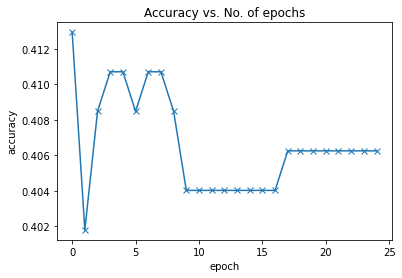

In [35]:
plot_accuracies(history)


In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

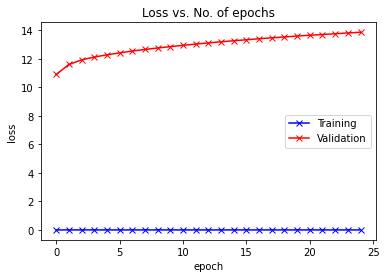

In [37]:
plot_losses(history)


In [40]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result


tensor([[-105.3400,  -53.9786,  -41.0301,  ...,   -8.3684,  -39.0421,
          -62.8753],
        [ -30.6007,  -30.9455,  -80.3478,  ...,  -43.1149,  -43.1996,
         -118.8497],
        [-165.8676, -195.0158,    6.1142,  ...,    5.1115, -165.2491,
         -104.4364],
        ...,
        [-119.2788,  -37.2552,  -34.8142,  ...,  -31.3349,  -58.6224,
          -44.4287],
        [ -81.9602, -106.2534,  -23.9456,  ...,   -2.5426, -108.0642,
          -82.3828],
        [ -42.3051,  -33.7976,  -55.3757,  ...,  -32.3350,  -42.3405,
          -59.9081]], device='cuda:0') tensor([47, 38,  7, 32, 32, 21, 45, 17, 20, 23, 44, 21, 33, 11, 44, 29, 28, 21,
        14, 46, 45,  5,  0, 33, 37, 42, 20, 10, 17, 48, 26, 19,  2, 44, 16, 31,
         0,  2, 13, 36, 39, 11,  0,  8,  3, 23,  2, 23, 39, 39, 15, 15,  2, 43,
        34,  1, 18, 11, 11, 13, 42, 22, 47, 10], device='cuda:0')
tensor([[-106.2179,  -88.2313,  -16.4491,  ...,    3.2464,  -71.0084,
          -31.1890],
        [ -24.7642,  -49.8

{'val_acc': 0.3368055522441864, 'val_loss': 14.226724624633789}

In [41]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')
